# 🚲 DC Bikers Diary – Data Loading & Initial Exploration

This notebook is part of our group homework for the DC Bikers Diary Challenge. In this stage, we:

- Mount Google Drive to access the data.
- Load and inspect the first few datasets (trips, weather, stations, etc.).
- Ensure all files are accessible and preview a few rows for sanity checks.

📁 Data is stored in a shared Drive folder:  
`/My Drive/DC_Bikers_Diary_Homework/data/`

👤 Team Members:
- Shayma Almthiab
- Reham Shaaban
- Mayar Ajaj

## 📦 Install Required Libraries

This cell installs all the Python libraries needed for this notebook.  
⚠️ Note: In Google Colab, these installations need to be re-run each time the session restarts.

In [1]:
# skip this if you're working locally
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install numpy scipy pandas folium plotly scikit-learn jupyterlab
# Install only if not already installed
try:
    import geopandas as gpd
    import pygeohash
    import prophet
except:
    !pip install geopandas pygeohash prophet pyarrow mapclassify


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 126.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 125.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.1/106.1 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 6.1.12
    Uninstalling jupyter-client-6.1.12:
      Successfully uninstalled jupyter-client-6.1.12
  Attempting uninstall:

## Imports

In [3]:
import os
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
from scipy.spatial import KDTree
import numpy as np
from geopandas.tools import sjoin_nearest
import plotly.express as px
import plotly.io as pio

## Setup Data Paths

In [11]:
# Define base data path
DATA_PATH = "drive/My Drive/DC_Bikers_Diary_Homework/Data"

# CSV Files
stations_file = os.path.join(DATA_PATH, "stations.csv")
weather_file = os.path.join(DATA_PATH, "weather_in_DC_2024.csv")
shuttle_bus_stops_file = os.path.join(DATA_PATH, "shuttle_bus_stops.csv")
metro_bus_stops_file = os.path.join(DATA_PATH, "metro_bus_stops.csv")
capital_bikeshare_locations_file = os.path.join(DATA_PATH, "capital_bikeshare_locations.csv")

# GeoJSON Files
residential_and_visitor_parking_zones_file = os.path.join(DATA_PATH, "residential_and_visitor_parking_zones.geojson")
DDOT_central_business_district_file = os.path.join(DATA_PATH, "DDOT_central_business_district.geojson")

# Parquet Files
daily_rent_file = os.path.join(DATA_PATH, "daily-rent.parquet")
daily_rent_sampled_file = os.path.join(DATA_PATH, "daily-rent-sampled.parquet")

## Load Data

In [12]:
# CSV Files
stations_df = pd.read_csv(stations_file)
weather_df = pd.read_csv(weather_file)
shuttle_bus_stops_df = pd.read_csv(shuttle_bus_stops_file)
metro_bus_stops_df = pd.read_csv(metro_bus_stops_file)
capital_bikeshare_locations_df = pd.read_csv(capital_bikeshare_locations_file)


# GeoJSON Files
residential_and_visitor_parking_zones_gdf = gpd.read_file(residential_and_visitor_parking_zones_file)
DDOT_central_business_district_gdf = gpd.read_file(DDOT_central_business_district_file)


# Parquet Files
daily_rent_df = pd.read_parquet(daily_rent_file)
daily_rent_sampled_df = pd.read_parquet(daily_rent_sampled_file)

## Helper Functions

In [13]:
def print_column_uniques(df, max_values=10):
    """
    Prints unique values and their counts for each column in a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame to inspect.
        max_values (int): Max number of unique values to print per column.
    """
    for col in df.columns:
        print(f"\n🟦 Column: {col}")
        print("-" * (10 + len(col)))

        unique_vals = df[col].unique()
        num_unique = len(unique_vals)
        print(f"🔹 Unique values count: {num_unique}")

        if num_unique <= max_values:
            print(df[col].value_counts(dropna=False))
        else:
            print(df[col].value_counts(dropna=False).head(max_values))
            print("... (more values not shown)")

In [14]:
def get_missing_info(df):
    """
    Returns a DataFrame summarizing data types, number of missing values,
    and missing value ratios per column — for columns with missing values only.

    Args:
        df (pd.DataFrame): The DataFrame to analyze.

    Returns:
        pd.DataFrame: Summary table with columns:
                      - data_type
                      - missing_val
                      - missing_val_ratio (as percentage)
                      Only includes columns where missing_val > 0.
    """
    info_df = pd.DataFrame(df.dtypes, columns=["data_type"])
    info_df['missing_val'] = df.isnull().sum()
    info_df['missing_val_ratio'] = (
        info_df['missing_val'] / len(df) * 100
    ).round().astype(int)

    # Only keep rows where there are missing values
    missing_info_df = info_df[info_df['missing_val'] > 0]

    return missing_info_df

In [15]:
def summarize_dataframe(df, max_sample_values=5, include_mode=True):
    """
    Summarizes each column in a DataFrame:
    - Data type
    - Missing values count
    - Unique values count
    - Min/Max for numeric and datetime types (object types show 'N/A' or alphabetical bounds)
    - Mode (most frequent values) for object/category types (optional)
    - Sample values (up to `max_sample_values`)

    Args:
        df (pd.DataFrame): The input DataFrame.
        max_sample_values (int): Maximum number of sample unique values to display.
        include_mode (bool): Whether to include the most frequent values (mode) for object/category columns.

    Returns:
        pd.DataFrame: A DataFrame summarizing each column.
    """
    summary_data = {
        "column": [],
        "dtype": [],
        "missing": [],
        "n_unique": [],
        "min": [],
        "max": [],
        "mode": [],
        "sample_values": []
    }

    for col in df.columns:
        data = df[col]
        dtype = data.dtype
        n_missing = data.isna().sum()
        n_unique = data.nunique(dropna=True)

        summary_data["column"].append(col)
        summary_data["dtype"].append(str(dtype))
        summary_data["missing"].append(n_missing)
        summary_data["n_unique"].append(n_unique)

        # Initialize min/max/mode as N/A
        current_min = "N/A"
        current_max = "N/A"
        current_mode = "N/A"


        # 1. Check for the most specific type (boolean) FIRST.
        if pd.api.types.is_bool_dtype(dtype):
            current_min = data.min() # Correctly handles False
            current_max = data.max() # Correctly handles True
            if not data.mode().empty:
                current_mode = data.mode().iloc[0]

        # 2. Now check for other numeric types.
        elif pd.api.types.is_numeric_dtype(dtype):
            current_min = round(data.min(), 4)
            current_max = round(data.max(), 4)
            if not data.mode().empty:
                current_mode = round(data.mode().iloc[0], 4)

        elif pd.api.types.is_datetime64_any_dtype(dtype):
            current_min = data.min()
            current_max = data.max()
            if not data.mode().empty:
                current_mode = data.mode().iloc[0]

        elif pd.api.types.is_string_dtype(dtype) or isinstance(dtype, pd.CategoricalDtype):
            non_na_data = data.dropna()
            if not non_na_data.empty:
                try:
                    sorted_vals = sorted([str(x) for x in non_na_data.unique()])
                    current_min = str(sorted_vals[0])
                    current_max = str(sorted_vals[-1])
                except TypeError:
                    pass

            if include_mode:
                mode_val = data.mode()
                if not mode_val.empty:
                    current_mode = str(mode_val.iloc[0])

        summary_data["min"].append(current_min)
        summary_data["max"].append(current_max)
        summary_data["mode"].append(current_mode)

        samples = data.dropna().unique()

        try:
            samples_str = [str(x) for x in samples[:max_sample_values]]
        except Exception:
            samples_str = ["Non-displayable values"]

        summary_data["sample_values"].append(samples_str)

    return pd.DataFrame(summary_data)

In [16]:
def check_duplicates(datasets, key):
    """
    Check duplicates in multiple datasets based on a key column.

    Args:
        datasets (dict): A dictionary where keys are dataset names and values are DataFrames.
        key (str): The column name to check for duplicates (e.g., 'ride_id').

    Prints:
        - Count of duplicates
        - Unique duplicated keys
        - Whether duplicates are identical or not
    """
    for name, df in datasets.items():
        print(f"\n🔍 Checking dataset: {name}")

        if key not in df.columns:
            print(f"❌ Key column '{key}' not found.")
            continue

        dup_mask = df.duplicated(subset=key, keep=False)
        dup_df = df[dup_mask]

        n_total = len(df)
        n_dups = dup_df.shape[0]
        n_unique_dups = dup_df[key].nunique()

        if n_dups == 0:
            print("✅ No duplicates found.")
            continue

        print(f"⚠️ {n_dups} duplicate rows found for {n_unique_dups} unique '{key}' values.")

        # Check if duplicates are identical or conflicting
        identical = dup_df.groupby(key).nunique().eq(1).all(axis=1).all()

        if identical:
            print("✅ All duplicate rows are identical.")
        else:
            print("⚠️ Some duplicate rows have conflicting values. Showing sample:")
            sample_keys = dup_df[key].value_counts().index[:3]
            for k in sample_keys:
                print(f"\nKey: {k}")
                print(df[df[key] == k])

## 👀 First Look at the Data

We inspect the first few rows of each dataset to:
- Verify successful loading.
- Understand column names and types.
- Check for obvious issues (e.g., nulls, strange formats).

In [ ]:
print("📍 Stations:")
stations_df.head()

📍 Stations:


,id,name
0,30200,9th St & Pennsylvania Ave NW
1,30201,9th & G St NW
2,31000,Eads St & 15th St S
3,31002,Crystal Dr & 20th St S
4,31003,Crystal Dr & 15th St S


In [ ]:
stations_df.info()
stations_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 821 entries, 0 to 820
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      821 non-null    int64 
 1   name    821 non-null    object
dtypes: int64(1), object(1)
memory usage: 13.0+ KB


(821, 2)

In [ ]:
print("🌤️ Weather:")
weather_df.head()

🌤️ Weather:


,name,datetime,tempmax,tempmin,temp,humidity,windspeed,windspeedmax,windspeedmean,windspeedmin,cloudcover,sunrise,sunset,moonphase,conditions,description,icon
0,"Washington,DC,USA",2024-01-01,6.1,3.8,4.9,74.7,21.9,21.9,11.9,0.0,90.3,2024-01-01T07:26:50,2024-01-01T16:56:30,0.68,"Rain, Overcast",Cloudy skies throughout the day with early mor...,rain
1,"Washington,DC,USA",2024-01-02,7.7,2.0,4.7,57.3,29.2,29.2,18.6,6.7,47.5,2024-01-02T07:26:58,2024-01-02T16:57:20,0.72,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
2,"Washington,DC,USA",2024-01-03,8.8,0.9,4.4,59.5,14.2,14.2,8.9,0.7,68.7,2024-01-03T07:27:04,2024-01-03T16:58:10,0.75,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
3,"Washington,DC,USA",2024-01-04,8.1,0.7,4.7,55.2,35.0,35.0,17.0,0.0,68.5,2024-01-04T07:27:07,2024-01-04T16:59:02,0.78,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
4,"Washington,DC,USA",2024-01-05,4.4,-2.4,0.9,55.0,21.3,21.3,10.6,5.1,44.5,2024-01-05T07:27:09,2024-01-05T16:59:55,0.81,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day


In [ ]:
weather_df.info()
weather_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           366 non-null    object 
 1   datetime       366 non-null    object 
 2   tempmax        366 non-null    float64
 3   tempmin        366 non-null    float64
 4   temp           366 non-null    float64
 5   humidity       366 non-null    float64
 6   windspeed      366 non-null    float64
 7   windspeedmax   366 non-null    float64
 8   windspeedmean  366 non-null    float64
 9   windspeedmin   366 non-null    float64
 10  cloudcover     366 non-null    float64
 11  sunrise        366 non-null    object 
 12  sunset         366 non-null    object 
 13  moonphase      366 non-null    float64
 14  conditions     366 non-null    object 
 15  description    366 non-null    object 
 16  icon           366 non-null    object 
dtypes: float64(10), object(7)
memory usage: 48.7+ KB


(366, 17)

In [ ]:
print("🚲 Shuttle Bus Stops:")
shuttle_bus_stops_df.head()

🚲 Shuttle Bus Stops:


,X,Y,COMPANY,ADDRESS,ATTRACTION,CROSSROADS,METERS,METRO_BUS_ZONE,METRO_STOP_ID,OTHER,...,YCOORD,LATITUDE,LONGITUDE,SE_ANNO_CAD_DATA,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,OBJECTID
0,-8.581105e+06,4.715777e+06,Reston Limousine,4350 JENIFER STREET NW,Mazza Gallarie,"4350 Jennifer St. NW, Washington, DC 20015 (pi...",No,No,NaN,No,...,143439.120000,38.958828,-77.085372,NaN,{4D096877-4394-4E04-AAC7-BC4E511C5B4A},NaN,NaN,DCGIS,2018/01/08 22:11:18+00,1
1,-8.571861e+06,4.714828e+06,Reston Limousine,550 GALLOWAY STREET NE,NaN,"550 Galloway St. NE, Washington, DC 20011 - Fo...",No,No,NaN,NaN,...,142700.050000,38.952201,-77.002336,NaN,{86FD8D0D-8512-4B67-BC46-F4702DDECBF7},NaN,NaN,DCGIS,2018/01/08 22:11:18+00,2
2,-8.580446e+06,4.714237e+06,American University,TENLEYTOWN - AU METRO STATION ENTRANCE - NORTH...,Tenley Town Metro,Albermarle St & 40th Street NW,No,Yes,1002492,No,...,142244.710000,38.948072,-77.079460,NaN,{39D07F3C-F0BC-4A81-A48E-B84F4476C0FB},NaN,NaN,DCGIS,2018/01/08 22:11:18+00,3
3,-8.580342e+06,4.714213e+06,American University,FORT DRIVE NW AND ALBEMARLE STREET NW,Metro on Fort road,Fort Drive & Albemarle St,No,Yes,1002498,No,...,142225.640001,38.947901,-77.078521,NaN,{F5F56BB9-4FA5-4990-A245-49BD5CE9FF56},NaN,NaN,DCGIS,2018/01/08 22:12:45+00,4
4,-8.580407e+06,4.713930e+06,American University,NEBRASKA AVENUE NW AND TENLEY CIRCLE NW,Tenley campus to Main Campus,Nebraska Ave NW & Tenley Circle,No,Yes,1003488,No,...,142006.200001,38.945924,-77.079102,NaN,{81C0AAA8-0A4A-46DB-B21F-290E8C261FB4},NaN,NaN,DCGIS,2018/01/08 22:12:45+00,5


In [ ]:
shuttle_bus_stops_df.columns

Index(['X', 'Y', 'COMPANY', 'ADDRESS', 'ATTRACTION', 'CROSSROADS', 'METERS',
       'METRO_BUS_ZONE', 'METRO_STOP_ID', 'OTHER', 'NPS', 'NUM_SHARED_OPER',
       'RUSH_HOUR_RESTR', 'LZ_HOTEL_OR_COMM', 'SPACE_LOC_ON_BLOCK',
       'NO_STOP_NO_STAND_AREA', 'MAR_ID', 'GIS_ID', 'XCOORD', 'YCOORD',
       'LATITUDE', 'LONGITUDE', 'SE_ANNO_CAD_DATA', 'GLOBALID', 'CREATOR',
       'CREATED', 'EDITOR', 'EDITED', 'OBJECTID'],
      dtype='object')

In [ ]:
shuttle_bus_stops_df.info()
shuttle_bus_stops_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X                      102 non-null    float64
 1   Y                      102 non-null    float64
 2   COMPANY                102 non-null    object 
 3   ADDRESS                102 non-null    object 
 4   ATTRACTION             76 non-null     object 
 5   CROSSROADS             84 non-null     object 
 6   METERS                 95 non-null     object 
 7   METRO_BUS_ZONE         93 non-null     object 
 8   METRO_STOP_ID          23 non-null     object 
 9   OTHER                  77 non-null     object 
 10  NPS                    0 non-null      float64
 11  NUM_SHARED_OPER        102 non-null    int64  
 12  RUSH_HOUR_RESTR        95 non-null     object 
 13  LZ_HOTEL_OR_COMM       95 non-null     object 
 14  SPACE_LOC_ON_BLOCK     93 non-null     object 
 15  NO_STO

(102, 29)

In [ ]:
print("🚲 Metro Bus Stops:")
metro_bus_stops_df.head()

🚲 Metro Bus Stops:


,X,Y,EGIS_ID,REG_ID,BSTP_GEO_ID,BSTP_OPS_TCD,BSTP_EFF_DATE,BSTP_TCD,AT_STR,ON_STR,...,SE_ANNO_CAD_DATA,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,OBJECTID,SNOWPRIORITY,BSTP_OPS_FTU_TCD,MSTN_ID
0,-8.581259e+06,4.715817e+06,1311739,1003448,15663,PRS,2011/08/22 04:00:00+00,UNK,44TH ST NW,JENIFER ST NW,...,NaN,{CFF25BD1-E9E8-44CD-81D6-975FE646753F},JLAY,2024/01/19 02:55:48+00,JLAY,2024/01/19 02:55:48+00,54845,NaN,NON,NaN
1,-8.540493e+06,4.714288e+06,1310541,3003035,14833,PRS,2001/12/30 05:00:00+00,REV,HARBOUR WAY,MITCHELLVILLE RD,...,NaN,{8E670BA7-FB63-4CAC-B9FC-C0901E266303},JLAY,2024/01/19 02:55:48+00,JLAY,2024/01/19 02:55:48+00,54846,NaN,NON,NaN
2,-8.591135e+06,4.698290e+06,1302469,5000849,2134,PRS,1901/01/01 05:00:00+00,REV,SLEEPY HOLLOW MANOR,COLUMBIA PIKE,...,NaN,{22649B1B-617C-4511-9786-D465C7142788},JLAY,2024/01/19 02:55:48+00,JLAY,2024/01/19 02:55:48+00,54847,NaN,NON,NaN
3,-8.577431e+06,4.682321e+06,1305286,5001858,11889,PRS,1974/11/25 05:00:00+00,REV,CUSHMAN PL,WAYNEWOOD BLVD,...,NaN,{AE0E1A3F-7C1D-4410-9E47-01B20568BBE0},JLAY,2024/01/19 02:55:48+00,JLAY,2024/01/19 02:55:48+00,54848,NaN,NON,NaN
4,-8.578561e+06,4.680594e+06,1305279,5001885,11919,PRS,1901/01/01 05:00:00+00,REV,PRICES LN,VERNON VIEW DR,...,NaN,{2C8845FF-D723-4334-A3DD-4DFEA1B1C4C2},JLAY,2024/01/19 02:55:48+00,JLAY,2024/01/19 02:55:48+00,54849,NaN,NON,NaN


In [ ]:
metro_bus_stops_df.columns

Index(['X', 'Y', 'EGIS_ID', 'REG_ID', 'BSTP_GEO_ID', 'BSTP_OPS_TCD',
       'BSTP_EFF_DATE', 'BSTP_TCD', 'AT_STR', 'ON_STR', 'BSTP_HDG',
       'BSTP_POS_TCD', 'BSTP_LDC', 'BSTP_MSG_TEXT', 'BSTP_LON', 'BSTP_LAT',
       'BSTP_LAT_LON_TCD', 'BSTP_INV_SYR_TCD', 'BSTP_INV_SRV_DATE',
       'BSTP_BNH_CNT', 'BSTP_BST_TCD', 'BSTP_IFC_OWN', 'BSTP_HAS_BKRS',
       'BSTP_HAS_PRS', 'BSTP_HAS_PVM', 'BSTP_HAS_PRM', 'BSTP_PDP_SIZE_TCD',
       'BSTP_PDP_MTR_TCD', 'BSTP_PDP_OBS_TCD', 'BSTP_PDP_HAS_CCN',
       'BSTP_HAS_BDR_PDP', 'BSTP_BDR_PDP_OBS', 'BSTP_SWK_WDT',
       'BSTP_SWK_HAS_CCN', 'BSTP_SWK_HAS_PPC', 'BSTP_SWK_SLP_WVL',
       'BSTP_SWK_OBS_TCD', 'BSTP_SWK_IPD_TCD', 'ONS_CRP_SLP', 'ONS_CRP',
       'OFS_CRP', 'AT_STR_ABS_CRP', 'AT_STR_OSS_CRP', 'ONS_CWK', 'OFS_CWK',
       'AT_STR_ABS_CWK', 'AT_STR_OSS_CWK', 'ON_STR_STS_OR_TFL',
       'ON_STR_PDC_SGL', 'AT_STR_PDC_SGL', 'BSTP_PRK_RST_TCD',
       'BSTP_NPK_ZNE_LTH', 'CNF_NPK_SNS', 'STR_LGT_WTN_30_FT',
       'BSTP_HAS_LED_DSP', 'BSTP_AC

In [ ]:
metro_bus_stops_df.info()
metro_bus_stops_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10044 entries, 0 to 10043
Data columns (total 79 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   X                  10044 non-null  float64
 1   Y                  10044 non-null  float64
 2   EGIS_ID            10044 non-null  int64  
 3   REG_ID             10044 non-null  int64  
 4   BSTP_GEO_ID        10044 non-null  int64  
 5   BSTP_OPS_TCD       10044 non-null  object 
 6   BSTP_EFF_DATE      10044 non-null  object 
 7   BSTP_TCD           10044 non-null  object 
 8   AT_STR             10044 non-null  object 
 9   ON_STR             10044 non-null  object 
 10  BSTP_HDG           10044 non-null  int64  
 11  BSTP_POS_TCD       10044 non-null  object 
 12  BSTP_LDC           9768 non-null   object 
 13  BSTP_MSG_TEXT      10044 non-null  object 
 14  BSTP_LON           10044 non-null  float64
 15  BSTP_LAT           10044 non-null  float64
 16  BSTP_LAT_LON_TCD   481

(10044, 79)

In [ ]:
print("🚲 Capital Bikeshare Locations:")
capital_bikeshare_locations_df.head()

🚲 Capital Bikeshare Locations:


,X,Y,NAME,STATION_TYPE,STATION_ID,STATION_STATUS,LAST_REPORTED,NUM_DOCKS_AVAILABLE,NUM_DOCKS_DISABLED,NUM_BIKES_AVAILABLE,...,EIGHTD_HAS_KEY_DISPENSER,CAPACITY,RENTAL_METHODS,REGION_ID,REGION_NAME,GIS_ID,LATITUDE,LONGITUDE,GIS_LAST_MOD_DTTM,OBJECTID
0,-8.577104e+06,4.705679e+06,Lincoln Memorial,classic,08254284-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:51+00,17,0,8,...,NO,25,"KEY,CREDITCARD",42.0,DCA-CABI,NaN,38.888255,-77.049437,2025/05/05 20:27:29+00,261284028
1,-8.609481e+06,4.714716e+06,W&OD Trail/Sunset Hills Rd & Isaac Newton Sq,classic,08263fbd-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:51+00,15,0,3,...,NO,19,"KEY,CREDITCARD",104.0,DCA-CABI,NaN,38.951419,-77.340281,2025/05/05 20:27:29+00,261284029
2,-8.575867e+06,4.705657e+06,17th St & Independence Ave SW,classic,082623bf-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:51+00,10,0,6,...,NO,19,"KEY,CREDITCARD",42.0,DCA-CABI,NaN,38.888097,-77.038325,2025/05/05 20:27:29+00,261284030
3,-8.574188e+06,4.706622e+06,8th & D St NW,classic,08256ac9-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:49+00,0,0,24,...,NO,24,"KEY,CREDITCARD",42.0,DCA-CABI,NaN,38.894851,-77.023240,2025/05/05 20:27:29+00,261284031
4,-8.567161e+06,4.706864e+06,Anacostia Ave & Benning Rd NE / River Terrace,classic,082518eb-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:49+00,4,0,10,...,NO,15,"KEY,CREDITCARD",42.0,DCA-CABI,NaN,38.896544,-76.960120,2025/05/05 20:27:29+00,261284032


In [ ]:
capital_bikeshare_locations_df.columns

Index(['X', 'Y', 'NAME', 'STATION_TYPE', 'STATION_ID', 'STATION_STATUS',
       'LAST_REPORTED', 'NUM_DOCKS_AVAILABLE', 'NUM_DOCKS_DISABLED',
       'NUM_BIKES_AVAILABLE', 'NUM_EBIKES_AVAILABLE', 'NUM_BIKES_DISABLED',
       'IS_INSTALLED', 'IS_RETURNING', 'IS_RENTING', 'HAS_KIOSK', 'IOS',
       'ANDROID', 'ELECTRIC_BIKE_SURCHARGE_WAIVER', 'EIGHTD_HAS_KEY_DISPENSER',
       'CAPACITY', 'RENTAL_METHODS', 'REGION_ID', 'REGION_NAME', 'GIS_ID',
       'LATITUDE', 'LONGITUDE', 'GIS_LAST_MOD_DTTM', 'OBJECTID'],
      dtype='object')

In [ ]:
capital_bikeshare_locations_df.info()
capital_bikeshare_locations_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794 entries, 0 to 793
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   X                               794 non-null    float64
 1   Y                               794 non-null    float64
 2   NAME                            794 non-null    object 
 3   STATION_TYPE                    794 non-null    object 
 4   STATION_ID                      794 non-null    object 
 5   STATION_STATUS                  0 non-null      float64
 6   LAST_REPORTED                   794 non-null    object 
 7   NUM_DOCKS_AVAILABLE             794 non-null    int64  
 8   NUM_DOCKS_DISABLED              794 non-null    int64  
 9   NUM_BIKES_AVAILABLE             794 non-null    int64  
 10  NUM_EBIKES_AVAILABLE            794 non-null    int64  
 11  NUM_BIKES_DISABLED              794 non-null    int64  
 12  IS_INSTALLED                    794 

(794, 29)

In [ ]:
print("🚲 Residential And Visitor Parking Zones:")
residential_and_visitor_parking_zones_gdf.head()

🚲 Residential And Visitor Parking Zones:


,NAME,RPP_ZONE,ANC_ID,WEB_URL,GIS_ID,SHAPE_LENG,CREATOR,CREATED,EDITOR,EDITED,OBJECTID,SHAPEAREA,SHAPELEN,geometry
0,ANC 4A,4,4A,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_17,19149.358478,None,None,None,None,1,0,0,"POLYGON ((-77.03331 38.98999, -77.03332 38.99,..."
1,ANC 3G,3,3G,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_16,13274.053932,None,None,None,None,2,0,0,"POLYGON ((-77.05161 38.98615, -77.05181 38.986..."
2,ANC 4B,4,4B,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_10,10937.574323,None,None,None,None,3,0,0,"POLYGON ((-76.99908 38.96328, -76.99909 38.963..."
3,ANC 3F,3,3F,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_15,11804.927060,None,None,None,None,4,0,0,"POLYGON ((-77.04702 38.96038, -77.04722 38.960..."
4,ANC 4C,4,4C,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_7,9774.918003,None,None,None,None,5,0,0,"POLYGON ((-77.02803 38.95622, -77.02804 38.956..."


In [ ]:
residential_and_visitor_parking_zones_gdf.columns

Index(['NAME', 'RPP_ZONE', 'ANC_ID', 'WEB_URL', 'GIS_ID', 'SHAPE_LENG',
       'CREATOR', 'CREATED', 'EDITOR', 'EDITED', 'OBJECTID', 'SHAPEAREA',
       'SHAPELEN', 'geometry'],
      dtype='object')

In [ ]:
residential_and_visitor_parking_zones_gdf.info()
residential_and_visitor_parking_zones_gdf.shape

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   NAME        40 non-null     object  
 1   RPP_ZONE    40 non-null     int32   
 2   ANC_ID      40 non-null     object  
 3   WEB_URL     40 non-null     object  
 4   GIS_ID      40 non-null     object  
 5   SHAPE_LENG  40 non-null     float64 
 6   CREATOR     0 non-null      object  
 7   CREATED     0 non-null      object  
 8   EDITOR      0 non-null      object  
 9   EDITED      0 non-null      object  
 10  OBJECTID    40 non-null     int32   
 11  SHAPEAREA   40 non-null     int32   
 12  SHAPELEN    40 non-null     int32   
 13  geometry    40 non-null     geometry
dtypes: float64(1), geometry(1), int32(4), object(8)
memory usage: 3.9+ KB


(40, 14)

In [ ]:
print("🚲 DDOT Central Business Distric:")
DDOT_central_business_district_gdf.head()

🚲 DDOT Central Business Distric:


,OBJECTID,ID,GIS_ID,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,SHAPEAREA,SHAPELEN,geometry
0,1,0,DDOT_CBD_1,{88E0BE6C-77A4-4C9B-96DA-39C3D223AA41},None,None,None,None,0,0,"POLYGON ((-77.05028 38.91194, -77.05029 38.911..."


In [ ]:
DDOT_central_business_district_gdf.columns

Index(['OBJECTID', 'ID', 'GIS_ID', 'GLOBALID', 'CREATOR', 'CREATED', 'EDITOR',
       'EDITED', 'SHAPEAREA', 'SHAPELEN', 'geometry'],
      dtype='object')

In [ ]:
DDOT_central_business_district_gdf.info()
DDOT_central_business_district_gdf.shape

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   OBJECTID   1 non-null      int32   
 1   ID         1 non-null      int32   
 2   GIS_ID     1 non-null      object  
 3   GLOBALID   1 non-null      object  
 4   CREATOR    0 non-null      object  
 5   CREATED    0 non-null      object  
 6   EDITOR     0 non-null      object  
 7   EDITED     0 non-null      object  
 8   SHAPEAREA  1 non-null      int32   
 9   SHAPELEN   1 non-null      int32   
 10  geometry   1 non-null      geometry
dtypes: geometry(1), int32(4), object(6)
memory usage: 204.0+ bytes


(1, 11)

In [ ]:
print("🚲 Daily Rent:")
daily_rent_df.head()

🚲 Daily Rent:


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,748A93D7DE8A41CD,classic_bike,2024-01-25 15:49:59,2024-01-25 15:52:35,1st & O St NW,31519,1st & L St NW,31677,38.908643,-77.012365,38.903819,-77.011987,member
1,75CBFD136F06305B,classic_bike,2024-01-02 16:44:58,2024-01-02 16:53:25,1st & O St NW,31519,4th & College St NW,31138,38.908643,-77.012365,38.921233,-77.018135,member
2,0536C9720F87E04C,classic_bike,2024-01-24 15:40:15,2024-01-24 15:43:55,1st & O St NW,31519,1st & L St NW,31677,38.908643,-77.012365,38.903819,-77.011987,member
3,9E17390C218783B5,classic_bike,2024-01-04 15:35:00,2024-01-04 15:37:35,1st & O St NW,31519,1st & L St NW,31677,38.908643,-77.012365,38.903819,-77.011987,member
4,00727D0E773CDFF7,electric_bike,2024-01-05 12:27:58,2024-01-05 12:35:40,1st & O St NW,31519,10th & G St NW,31274,38.908690,-77.012317,38.898243,-77.026235,casual


In [ ]:
daily_rent_df.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual'],
      dtype='object')

In [ ]:
daily_rent_df.info()
daily_rent_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6114323 entries, 0 to 6114322
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             string        
 1   rideable_type       string        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  string        
 5   start_station_id    string        
 6   end_station_name    string        
 7   end_station_id      string        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       string        
dtypes: datetime64[ns](2), float64(4), string(7)
memory usage: 606.4 MB


(6114323, 13)

In [ ]:
print("🚲 Daily Rent Sampled:")
daily_rent_sampled_df.head()

🚲 Daily Rent Sampled:


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,6A6067934F2E1EC9,classic_bike,2024-05-04 14:27:37,2024-05-04 14:37:52,14th & G St NW,31238,Jefferson Memorial,31249,38.898164,-77.031898,38.879819,-77.037413,casual
1,FF5D6FE256D4DE34,classic_bike,2024-05-04 14:00:53,2024-05-04 15:00:25,Jefferson Dr & 14th St SW,31247,7th & F St NW / National Portrait Gallery,31232,38.888553,-77.032427,38.897283,-77.022191,casual
2,4A64EABCDCB7506A,classic_bike,2024-05-04 15:12:21,2024-05-04 15:27:29,1st & M St NE,31603,4th & M St SW,31108,38.905697,-77.005483,38.876823,-77.017774,casual
3,0F7347CF6409CEB7,classic_bike,2024-05-04 14:49:59,2024-05-04 14:54:11,Jefferson Memorial,31249,Hains Point/Buckeye & Ohio Dr SW,31273,38.879819,-77.037413,38.878433,-77.030230,casual
4,2022D12F38B197C3,classic_bike,2024-05-04 19:23:20,2024-05-04 19:41:35,New Hampshire Ave & T St NW,31229,14th & G St NW,31238,38.915544,-77.038252,38.898164,-77.031898,casual


In [ ]:
daily_rent_sampled_df.shape

(2018456, 13)

# 1.1 Let's Clean Up Some Data!

We'll start by preprocessing the data: checking for and handling missing values

## **1. Shuttle Bus Stops Dataset**

starting off with the **Shuttle Bus Stops Dataset**, since the stations and weather datasets don't have any missing values per the initial inspection, they're safe (for now)

- ***Purpose of the dataset*** : Pickup and drop off locations for shuttle buses operated by sight seeing, ride share and educational organizations.

### Step 1:🧹 Let's starting by dropping totally useless columns

In [ ]:
# let's check for missing values in-depth
missing_info = get_missing_info(shuttle_bus_stops_df)
display(missing_info.sort_values("missing_val_ratio", ascending=False))

,data_type,missing_val,missing_val_ratio
CREATED,float64,102,100
NPS,float64,102,100
SE_ANNO_CAD_DATA,float64,102,100
CREATOR,float64,102,100
METRO_STOP_ID,object,79,77
ATTRACTION,object,26,25
OTHER,object,25,25
CROSSROADS,object,18,18
SPACE_LOC_ON_BLOCK,object,9,9
METRO_BUS_ZONE,object,9,9


In [ ]:
# First: Dropping all NULL coulmns
cols_100_nulls = [
    "NPS", "SE_ANNO_CAD_DATA", "CREATOR", "CREATED"
]
shuttle_bus_stops_df.drop(columns=cols_100_nulls, inplace=True)

In [ ]:
print_column_uniques(shuttle_bus_stops_df)


🟦 Column: X
-----------
🔹 Unique values count: 96
X
-8.580407e+06    2
-8.580930e+06    2
-8.581164e+06    2
-8.577422e+06    2
-8.576568e+06    2
-8.577218e+06    2
-8.580342e+06    1
-8.582103e+06    1
-8.570625e+06    1
-8.580530e+06    1
Name: count, dtype: int64
... (more values not shown)

🟦 Column: Y
-----------
🔹 Unique values count: 96
Y
4.713930e+06    2
4.713135e+06    2
4.712783e+06    2
4.710917e+06    2
4.708923e+06    2
4.707483e+06    2
4.714213e+06    1
4.713874e+06    1
4.713552e+06    1
4.713736e+06    1
Name: count, dtype: int64
... (more values not shown)

🟦 Column: COMPANY
-----------------
🔹 Unique values count: 25
COMPANY
Reston Limousine              30
CitySights DC                 14
American University           11
International Limousine        9
Georgetown University          6
Abe's Transportation Inc.      4
Open Top                       3
Chariots for Hire              3
Open Top                       3
Old Town & Open Top            2
Name: count, dt

after further inspection, we will be dropping these following columns as well ! (all of them are either ID columns or contain no relevant or meaningful info)


| Column     | Reason to Drop                                                 |
| ---------- | -------------------------------------------------------------- |
| `OBJECTID` | Just a row index in the GIS system (not meaningful)            |
| `GLOBALID` | Globally unique ID, useful in syncing GIS systems: not needed |
| `EDITOR`   | Always `"DCGIS"` no variation → no value                     |
| `EDITED`   | Timestamps only   |
| `GIS_ID`   | Same as `OBJECTID`, different format                           |
| `MAR_ID`   | Internal map registry ID (used by DC gov, not us)             |
| `X`, `Y`   | Duplicates of the longitude/latitude stored in the `geometry` column (redundant) |
| `XCOORD`, `YCOORD` | Raw projection-based coordinates from GIS system (not used in analysis)    |



In [ ]:
# Second : let's drop useless obvious useless columns
columns_to_drop = ["OBJECTID", "GLOBALID", "EDITOR", "EDITED", "GIS_ID", "MAR_ID", "X", "Y", "XCOORD", "YCOORD"]
shuttle_bus_stops_df.drop(columns=columns_to_drop, inplace=True)

shuttle_bus_stops_df.head()

,COMPANY,ADDRESS,ATTRACTION,CROSSROADS,METERS,METRO_BUS_ZONE,METRO_STOP_ID,OTHER,NUM_SHARED_OPER,RUSH_HOUR_RESTR,LZ_HOTEL_OR_COMM,SPACE_LOC_ON_BLOCK,NO_STOP_NO_STAND_AREA,LATITUDE,LONGITUDE
0,Reston Limousine,4350 JENIFER STREET NW,Mazza Gallarie,"4350 Jennifer St. NW, Washington, DC 20015 (pi...",No,No,NaN,No,1,No,Yes,Eastbound/Rightside,Yes,38.958828,-77.085372
1,Reston Limousine,550 GALLOWAY STREET NE,NaN,"550 Galloway St. NE, Washington, DC 20011 - Fo...",No,No,NaN,NaN,1,No,No,Eastbound / Rightside,No,38.952201,-77.002336
2,American University,TENLEYTOWN - AU METRO STATION ENTRANCE - NORTH...,Tenley Town Metro,Albermarle St & 40th Street NW,No,Yes,1002492,No,1,No,No,Southbound/Right side,No,38.948072,-77.079460
3,American University,FORT DRIVE NW AND ALBEMARLE STREET NW,Metro on Fort road,Fort Drive & Albemarle St,No,Yes,1002498,No,1,No,No,Northbound/ Right Side,No,38.947901,-77.078521
4,American University,NEBRASKA AVENUE NW AND TENLEY CIRCLE NW,Tenley campus to Main Campus,Nebraska Ave NW & Tenley Circle,No,Yes,1003488,No,1,No,No,Southwest bound/Rightside,No,38.945924,-77.079102


###  Step 2 :🧹 Handling Missing Values

Several columns in this dataset contain missing or unclear values (NaNs or "?")
Since the dataset is very small already, so we won't be dropping any rows!
  
**1.`ATTRACTION`** (25% missing)
--> we will be replacing them with "None" -- as in there are no nearby landmarks or points of interest.

**2.`CROSSROADS`** (18% missing)
--> we will be replacing them with "Unknown" -- we don't know the nearest intersecting streets or junction.

**3. `OTHER`** (25% missing)
--> we will be replacing them with "None" -- as in there are no additional notes about the stop.

**4. `METRO_STOP_ID`** (77% missing)
--> *for now* we will replace them with "None"
--> This column might be useful later if we join it with a Metro dataset for spatial analysis. Otherwise, we may drop it.

**5. `METRO_BUS_ZONE`** (9% missing)
--> will be replaced with "Unknown", we don't know whether this is a metro stop zone or not.

**6. `METERS`** (7% missing)
--> Replaced with "Unknown".  
📝 The meaning of this column is unclear; we retain it in case it becomes relevant later.

**7. `RUSH_HOUR_RESTR`** (7% missing)
--> will be replaced with "No Info", we don't know whether this bus stop has a rush hour restriction or not.

**8. `LZ_HOTEL_OR_COMM`** (7% missing)
--> will be replaced with "No Info", we don't know whether this bus stop is in a hotel or comm zone.

**9. `SPACE_LOC_ON_BLOCK`** (9% missing)
--> will be replaced with "No Info"
--> We may be able to **derive this spatially** later (from direction or street geometry). Also needs text normalization.

**10. `NO_STOP_NO_STAND_AREA`** (8% missing)
--> will be replaced with "No Info", we don't know whether this is a restricted stopping/standing zone

In [ ]:
# Fill missing/uncertain categorical values with descriptive defaults
fillna_values = {
    "ATTRACTION": "None",
    "CROSSROADS": "Unknown",
    "METRO_STOP_ID": "None",
    "METRO_BUS_ZONE": "Unknown",
    "METERS": "Unknown",
    "OTHER": "No",
    "RUSH_HOUR_RESTR": "No Info",
    "LZ_HOTEL_OR_COMM": "No Info",
    "SPACE_LOC_ON_BLOCK": "No Info",
    "NO_STOP_NO_STAND_AREA": "No Info"
}

# Apply replacements for missing (NaN)
shuttle_bus_stops_df.fillna(value=fillna_values, inplace=True)

# Normalize inconsistent values like "?" and "Maybe"
value_replacements = {
    "RUSH_HOUR_RESTR": {"?": "No Info"},
    "LZ_HOTEL_OR_COMM": {"?": "No Info"},
    "NO_STOP_NO_STAND_AREA": {"?": "No Info", "Maybe": "No Info"},
    "METRO_BUS_ZONE": {"?": "Unknown"},
    "SPACE_LOC_ON_BLOCK": {"?": "No Info"},
    "METERS": {"Maybe": "Unknown"}
}

for col, replacements in value_replacements.items():
    shuttle_bus_stops_df[col] = shuttle_bus_stops_df[col].replace(replacements)

In [ ]:
# let's check now!
missing_info = get_missing_info(shuttle_bus_stops_df)
display(missing_info.sort_values("missing_val_ratio", ascending=False))

,data_type,missing_val,missing_val_ratio


###  Step 3 :🧹 Cleaning Messy Values

1. `COMPANY` :
-- we notice that the column `COMPANY` has some messy values :
- Duplicated company names in varying order
- Inconsistent separators (`&`, `,`, "and")
- Mixed capitalization and spacing
***Examples:***
1. "Open Top & DC Trails & CitySights DC" vs "CitySights DC, Open Top, DC Trails" (same company, different order and separators)
2. "Open Top"   --> appears more than once but is treated as two different values

In [ ]:
# Before cleaning
shuttle_bus_stops_df["COMPANY"].value_counts()

COMPANY
Reston Limousine                                                        30
CitySights DC                                                           14
American University                                                     11
International Limousine                                                  9
Georgetown University                                                    6
Abe's Transportation Inc.                                                4
Open Top                                                                 3
Chariots for Hire                                                        3
Open Top                                                                 3
Old Town & Open Top                                                      2
Open Top & DC Trails & CitySights DC                                     2
Open Top & DC Trails                                                     2
CitySights DC, Open Top, DC Trails                                       1
International Lim

In [ ]:
# Lowercase all entries for consistency
shuttle_bus_stops_df["COMPANY"] = shuttle_bus_stops_df["COMPANY"].str.lower()

# Replace common separators (&, and) with commas
shuttle_bus_stops_df["COMPANY"] = shuttle_bus_stops_df["COMPANY"].str.replace(r'\s*&\s*|\s*and\s*', ',', regex=True)

# Split, clean, sort, and rejoin company names
shuttle_bus_stops_df["COMPANY"] = shuttle_bus_stops_df["COMPANY"].apply(lambda cell: ", ".join(sorted(set(p.strip() for p in cell.split(",") if p.strip()))))

# View cleaned results
shuttle_bus_stops_df["COMPANY"].value_counts()

COMPANY
reston limousine                                                   30
citysights dc                                                      14
american university                                                11
international limousine                                             9
georgetown university                                               6
open top                                                            6
abe's transportation inc.                                           4
citysights dc, dc trails, open top                                  3
old town, open top                                                  3
chariots for hire                                                   3
dc trails, open top                                                 2
international limousine, reston limousine                           1
citysights dc, open top                                             1
old town                                                            1
dc trails, o

2. `SPACE_LOC_ON_BLOCK` :
-- we notice that the column `SPACE_LOC_ON_BLOCK` has some messy values :
- Duplicated values due to inconsistent punctionation, casing or typos
***Examples:***
1. 'Eastbound/Rightside', 'Eastbound / Rightside' , 'East bound/ Rightside' , 'Eastbound/ Right Side' (duplicate values due to spacing)
2. 'Notheast bound/Rightside' (typo)
3. Northwest bound/Right Side , Northwest/Left side' & South bound/ Rightside , Southside/ Rightside (duplicate due to inconsistent naming)

In [ ]:
# before cleaning
shuttle_bus_stops_df["SPACE_LOC_ON_BLOCK"].value_counts()

SPACE_LOC_ON_BLOCK
Westbound/Right Side            14
No Info                         12
Eastbound/Rightside              8
Southwest bound/Rightside        7
Southbound/Rightside             7
Northeast bound / Rightside      5
Eastbound/ Rightside             5
Northbound/Right Side            5
Northwest bound/ Right Side      4
Northbound/ Right Side           4
Eastbound/ Right Side            4
NorthWestbound/Right Side        3
Northwest bound/Rightside        3
Northbound/Rightside             3
Southeast bound / Right Side     2
Southbound/Right side            2
Southeastbound / Right Side      2
Northwest bound/ Right side      1
Eastbound / Rightside            1
East bound/ Leftside             1
Southeast bound/Right Side       1
East bound/ Rightside            1
Eastbound/ Leftside              1
Southside/ Rightside             1
South bound/ Rightside           1
Northwest bound/Right Side       1
Nothbound/ Rightside             1
Northwest/Left side              1
N

In [ ]:
# Clean and normalize SPACE_LOC_ON_BLOCK column
shuttle_bus_stops_df["SPACE_LOC_ON_BLOCK"] = (
    shuttle_bus_stops_df["SPACE_LOC_ON_BLOCK"]
    .str.lower()
    .str.replace("nothbound", "northbound")
    .str.replace("notheast", "northeast")
    .str.replace(r'\s*/\s*', ' / ', regex=True)
    .str.replace(r'\s+', ' ', regex=True)
    .str.replace(r'(\w+)\s+bound', r'\1bound', regex=True)
    .str.replace(r'bound', '', regex=True)
    .str.replace(r'(\w+)\s+side', r'\1side', regex=True)
    .str.replace(r'side', '', regex=True)
    .str.strip()
)

# View cleaned results
shuttle_bus_stops_df["SPACE_LOC_ON_BLOCK"].value_counts().sort_index()

SPACE_LOC_ON_BLOCK
east / left           2
east / right         19
no info              12
north / right        13
northeast / right     6
northwest / left      1
northwest / right    12
south / right        11
southeast / right     5
southwest / right     7
west / right         14
Name: count, dtype: int64

### Finally, let's turn this DataFrame into a GeoDataFrame

In [ ]:
shuttle_bus_stops_df['geometry'] = shuttle_bus_stops_df.apply(lambda row: Point(row['LONGITUDE'], row['LATITUDE']), axis=1)
shuttle_gdf = gpd.GeoDataFrame(shuttle_bus_stops_df, geometry='geometry', crs="EPSG:4326")

In [ ]:
# Drop the LONGITUDE and LATITUDE columns --> not needed anymore
shuttle_gdf.drop(columns=["LONGITUDE","LATITUDE"], inplace=True)

<Axes: >

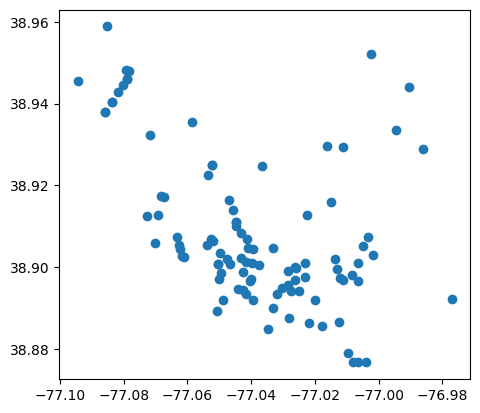

In [ ]:
shuttle_gdf.plot()

In [ ]:
summary_df = summarize_dataframe(shuttle_gdf)
display(summary_df)

,column,dtype,missing,n_unique,min,max,mode,sample_values
0,COMPANY,object,0,22,abe's transportation inc.,tbd,reston limousine,"[reston limousine, american university, intern..."
1,ADDRESS,object,0,98,1 WASHINGTON CIRCLE NW,TENLEYTOWN - AU METRO STATION ENTRANCE - NORTH...,CONNECTICUT AVENUE NW AND 24TH STREET NW,"[4350 JENIFER STREET NW, 550 GALLOWAY STREET N..."
2,ATTRACTION,object,0,72,American College of Cardiology,Woodley Park Metro Station,None,"[Mazza Gallarie , None, Tenley Town Metro, Met..."
3,CROSSROADS,object,0,81,10th & F St. NW,Wisconsin Ave. NW & M St. NW,Unknown,"[4350 Jennifer St. NW, Washington, DC 20015 (p..."
4,METERS,object,0,3,No,Yes,No,"[No, Unknown, Yes]"
5,METRO_BUS_ZONE,object,0,3,No,Yes,No,"[No, Yes, Unknown]"
6,METRO_STOP_ID,object,0,23,1000854,None,None,"[None, 1002492, 1002498, 1003488, 1002427]"
7,OTHER,object,0,21,Circulator Stop,Two hour zone 3 parking,No,"[No, Existing Sign , Taxicab Stand , Two hour ..."
8,NUM_SHARED_OPER,int64,0,5,1,5,1,"[1, 3, 2, 4, 5]"
9,RUSH_HOUR_RESTR,object,0,3,No,Yes,No,"[No, No Info, Yes]"


## **2. Metro Bus Stop Dataset**

***Purpose*** : WMATA Regional Bus Stops. The dataset includes bus stop identification, location, and inventory information.

In [ ]:
# let's check for missing values in-depth
missing_info = get_missing_info(metro_bus_stops_df)
display(missing_info.sort_values("missing_val_ratio", ascending=False))

,data_type,missing_val,missing_val_ratio
SE_ANNO_CAD_DATA,float64,10044,100
MSTN_ID,object,9777,97
SNOWPRIORITY,object,9497,95
BSTP_LAT_LON_TCD,object,9563,95
BLOCKKEY,object,7025,70
OFFSET,float64,6874,68
ROUTEID,object,6874,68
MEASURE,float64,6874,68
BLOCKFACEKEY,object,6876,68
BSTP_LDC,object,276,3


## **3. Capital Bikeshare Locations Dataset**


***Purpose*** :  The dataset contains locations and attributes of Capital Bikeshare sites. These are offer bikes to travel throughout the District for a fee.

### 🧹 Step 1: Let's starting by dropping totally useless columns:

A Few Notes :

- **STATION_STATUS**  
  As described in the dataset metadata, this column indicates whether a station is active or out of service.  
  However, this status is already captured by the `IS_RETURNING` column:
  - If `IS_RETURNING == FALSE` --> the station is out of service  
  - If `IS_RETURNING == TRUE` --> the station is active  
  Since STATION_STATUS is entirely null and redundant, it can be safely dropped.

- **GIS_ID**  
  Defined as the *"OCTO GIS sequential identifier"*. All values are missing (`NaN`).  
  --> Dropped.

- **REGION_ID**  
  Some values are missing. However, the metadata maps each ID to a known geographic region (e.g., DC, Arlington, Fairfax).  
  These missing values can potentially be filled via spatial join or inferred using latitude/longitude.  
  --> Kept for now.


In [17]:
# let's check for missing values in-depth
missing_info = get_missing_info(capital_bikeshare_locations_df)
display(missing_info.sort_values("missing_val_ratio", ascending=False))

,data_type,missing_val,missing_val_ratio
STATION_STATUS,float64,794,100
GIS_ID,float64,794,100
REGION_ID,float64,50,6


In [18]:
# First: Dropping all NULL coulmns
cols_100_nulls = [
    "STATION_STATUS", "GIS_ID"
]
capital_bikeshare_locations_df.drop(columns=cols_100_nulls, inplace=True)

In [ ]:
print_column_uniques(capital_bikeshare_locations_df, max_values=50)


🟦 Column: X
-----------
🔹 Unique values count: 794
X
-8.577104e+06    1
-8.609481e+06    1
-8.575867e+06    1
-8.574188e+06    1
-8.567161e+06    1
-8.558021e+06    1
-8.577479e+06    1
-8.573150e+06    1
-8.581470e+06    1
-8.559494e+06    1
-8.572949e+06    1
-8.575519e+06    1
-8.580744e+06    1
-8.573122e+06    1
-8.572593e+06    1
-8.566037e+06    1
-8.601828e+06    1
-8.571171e+06    1
-8.575239e+06    1
-8.614410e+06    1
-8.582130e+06    1
-8.567226e+06    1
-8.577105e+06    1
-8.583605e+06    1
-8.563287e+06    1
-8.574795e+06    1
-8.583414e+06    1
-8.572009e+06    1
-8.580105e+06    1
-8.601991e+06    1
-8.589015e+06    1
-8.571293e+06    1
-8.575240e+06    1
-8.609303e+06    1
-8.571818e+06    1
-8.566499e+06    1
-8.590090e+06    1
-8.571033e+06    1
-8.576464e+06    1
-8.571424e+06    1
-8.572381e+06    1
-8.611645e+06    1
-8.569772e+06    1
-8.570133e+06    1
-8.610104e+06    1
-8.585825e+06    1
-8.578727e+06    1
-8.597290e+06    1
-8.611839e+06    1
-8.608536e+06  

In [19]:
matches = capital_bikeshare_locations_df[capital_bikeshare_locations_df["IS_RENTING"].str.contains("NO")]
matches

,X,Y,NAME,STATION_TYPE,STATION_ID,LAST_REPORTED,NUM_DOCKS_AVAILABLE,NUM_DOCKS_DISABLED,NUM_BIKES_AVAILABLE,NUM_EBIKES_AVAILABLE,...,ELECTRIC_BIKE_SURCHARGE_WAIVER,EIGHTD_HAS_KEY_DISPENSER,CAPACITY,RENTAL_METHODS,REGION_ID,REGION_NAME,LATITUDE,LONGITUDE,GIS_LAST_MOD_DTTM,OBJECTID
163,-8.571013e+06,4.705110e+06,Pennsylvania Ave & 8th St SE,classic,08249e81-1f3f-11e7-bf6b-3863bb334450,1970/01/02 01:00:00+00,0,0,0,0,...,NO,NO,23,"KEY,CREDITCARD",42.0,DCA-CABI,38.884275,-76.994716,2025/05/05 20:27:29+00,261284191
478,-8.579649e+06,4.706586e+06,Wilson Blvd & Ft Myer Dr,classic,0824eb1b-1f3f-11e7-bf6b-3863bb334450,2025/05/05 20:17:36+00,12,0,0,0,...,NO,NO,19,"KEY,CREDITCARD",41.0,DCA-CABI,38.894600,-77.072305,2025/05/05 20:27:29+00,261284506
685,-8.569321e+06,4.712070e+06,18th & Monroe St NE,classic,0826547e-1f3f-11e7-bf6b-3863bb334450,2025/05/05 10:47:12+00,4,0,0,0,...,NO,NO,19,"KEY,CREDITCARD",42.0,DCA-CABI,38.932930,-76.979517,2025/05/05 20:27:30+00,261291753
735,-8.572230e+06,4.707700e+06,1st & K St NE,classic,b8b6903d-fabc-48aa-af9b-2c5fb29344b9,2025/05/05 20:26:34+00,0,0,0,0,...,NO,NO,17,"KEY,CREDITCARD",42.0,DCA-CABI,38.902386,-77.005649,2025/05/05 20:27:30+00,261291803


In [20]:
matches = capital_bikeshare_locations_df[capital_bikeshare_locations_df["IS_RETURNING"].str.contains("NO")]
matches

,X,Y,NAME,STATION_TYPE,STATION_ID,LAST_REPORTED,NUM_DOCKS_AVAILABLE,NUM_DOCKS_DISABLED,NUM_BIKES_AVAILABLE,NUM_EBIKES_AVAILABLE,...,ELECTRIC_BIKE_SURCHARGE_WAIVER,EIGHTD_HAS_KEY_DISPENSER,CAPACITY,RENTAL_METHODS,REGION_ID,REGION_NAME,LATITUDE,LONGITUDE,GIS_LAST_MOD_DTTM,OBJECTID
163,-8.571013e+06,4.705110e+06,Pennsylvania Ave & 8th St SE,classic,08249e81-1f3f-11e7-bf6b-3863bb334450,1970/01/02 01:00:00+00,0,0,0,0,...,NO,NO,23,"KEY,CREDITCARD",42.0,DCA-CABI,38.884275,-76.994716,2025/05/05 20:27:29+00,261284191
478,-8.579649e+06,4.706586e+06,Wilson Blvd & Ft Myer Dr,classic,0824eb1b-1f3f-11e7-bf6b-3863bb334450,2025/05/05 20:17:36+00,12,0,0,0,...,NO,NO,19,"KEY,CREDITCARD",41.0,DCA-CABI,38.894600,-77.072305,2025/05/05 20:27:29+00,261284506
685,-8.569321e+06,4.712070e+06,18th & Monroe St NE,classic,0826547e-1f3f-11e7-bf6b-3863bb334450,2025/05/05 10:47:12+00,4,0,0,0,...,NO,NO,19,"KEY,CREDITCARD",42.0,DCA-CABI,38.932930,-76.979517,2025/05/05 20:27:30+00,261291753
735,-8.572230e+06,4.707700e+06,1st & K St NE,classic,b8b6903d-fabc-48aa-af9b-2c5fb29344b9,2025/05/05 20:26:34+00,0,0,0,0,...,NO,NO,17,"KEY,CREDITCARD",42.0,DCA-CABI,38.902386,-77.005649,2025/05/05 20:27:30+00,261291803


A Few Notes :

- **EIGHTD_HAS_KEY_DISPENSER**  & **ELECTRIC_BIKE_SURCHARGE_WAIVER**

All valuse of both of these column is "No". It offers no info --> Dropped

- **STATION_TYPE**  

All values are "classic" (not useful) --> Dropped

- **REGION_NAME**

All values are "DCA-CABI" (not useful) --> Dropped

- **OBJECTID**

Described as *Internal feature number* and *sequential unique whole numbers that are automatically generated* (Redundant and not useful since we already have station id) --> Dropped.

- **IOS**  & **ANDROID**

Constant values, not useful for analysis --> Dropped

- **RENTAL_METHODS**

Constant values, not useful for analysis --> Dropped

- **GIS_LAST_MOD_DTTM** & **LAST_REPORTED**

Last time and date the information was updated and the last time this station reported its status to the operator's backend. (not really useful for analysis could be used for freshness) --> Dropped

- **IS_RENTING**

We suspected that if **IS_RETURNING** is true (station is active), then so is **IS_RENTING**. after further inspection we found that the same 4 stations that are not returning are in fact not renting and thus, inactive. we opted to drop one of the columns and rename the other as STATION_STATUS as it captures all relevant info.


In [21]:
# Second: Dropping columns that are meaningless/useless
columns_to_drop = [
    "IOS", "ANDROID", "EIGHTD_HAS_KEY_DISPENSER", "ELECTRIC_BIKE_SURCHARGE_WAIVER",
    "STATION_TYPE", "GIS_LAST_MOD_DTTM", "LAST_REPORTED", "IS_RENTING", "OBJECTID", "REGION_NAME", "RENTAL_METHODS", "X", "Y", "STATION_ID"
]
capital_bikeshare_locations_df.drop(columns=columns_to_drop, inplace=True)
capital_bikeshare_locations_df = capital_bikeshare_locations_df.rename(columns={"IS_RETURNING": "STATION_STATUS"})
capital_bikeshare_locations_df["STATION_STATUS"] = (
    capital_bikeshare_locations_df["STATION_STATUS"]
    .str.replace("YES", "ACTIVE")
    .str.replace("NO", "INACTIVE")
)
capital_bikeshare_locations_df.head()

,NAME,NUM_DOCKS_AVAILABLE,NUM_DOCKS_DISABLED,NUM_BIKES_AVAILABLE,NUM_EBIKES_AVAILABLE,NUM_BIKES_DISABLED,IS_INSTALLED,STATION_STATUS,HAS_KIOSK,CAPACITY,REGION_ID,LATITUDE,LONGITUDE
0,Lincoln Memorial,17,0,8,0,0,YES,ACTIVE,YES,25,42.0,38.888255,-77.049437
1,W&OD Trail/Sunset Hills Rd & Isaac Newton Sq,15,0,3,0,1,YES,ACTIVE,YES,19,104.0,38.951419,-77.340281
2,17th St & Independence Ave SW,10,0,6,4,1,YES,ACTIVE,YES,19,42.0,38.888097,-77.038325
3,8th & D St NW,0,0,24,0,0,YES,ACTIVE,NO,24,42.0,38.894851,-77.023240
4,Anacostia Ave & Benning Rd NE / River Terrace,4,0,10,0,1,YES,ACTIVE,YES,15,42.0,38.896544,-76.960120


### Finally, let's turn this DataFrame into a GeoDataFrame

In [22]:
capital_bikeshare_locations_df['geometry'] = capital_bikeshare_locations_df.apply(lambda row: Point(row['LONGITUDE'], row['LATITUDE']), axis=1)
capital_gdf = gpd.GeoDataFrame(capital_bikeshare_locations_df, geometry='geometry', crs="EPSG:4326")

In [23]:
# Drop the LONGITUDE and LATITUDE columns --> not needed anymore
capital_gdf.drop(columns=["LONGITUDE","LATITUDE"], inplace=True)

<Axes: >

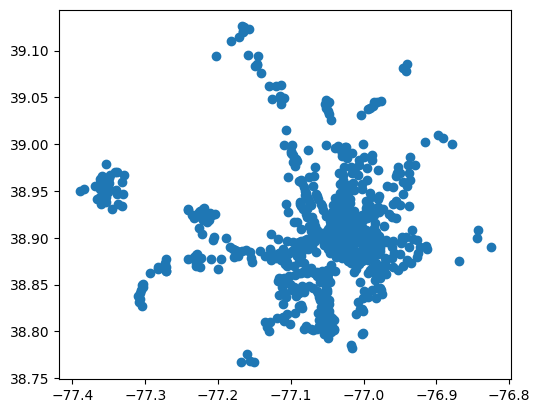

In [24]:
capital_gdf.plot()

In [25]:
summary_df = summarize_dataframe(capital_gdf)
display(summary_df)

,column,dtype,missing,n_unique,min,max,mode,sample_values
0,NAME,object,0,794,S Scott St & 13th St S,Yuma St & Tenley Circle NW,S Scott St & 13th St S,"[Lincoln Memorial, W&OD Trail/Sunset Hills Rd ..."
1,NUM_DOCKS_AVAILABLE,int64,0,33,0,32,12,"[17, 15, 10, 0, 4]"
2,NUM_DOCKS_DISABLED,int64,0,3,0,7,0,"[0, 1, 7]"
3,NUM_BIKES_AVAILABLE,int64,0,31,0,41,2,"[8, 3, 6, 24, 10]"
4,NUM_EBIKES_AVAILABLE,int64,0,10,0,15,0,"[0, 4, 1, 5, 2]"
5,NUM_BIKES_DISABLED,int64,0,8,0,15,0,"[0, 1, 3, 2, 6]"
6,IS_INSTALLED,object,0,2,NO,YES,YES,"[YES, NO]"
7,STATION_STATUS,object,0,2,ACTIVE,INACTIVE,ACTIVE,"[ACTIVE, INACTIVE]"
8,HAS_KIOSK,object,0,2,NO,YES,YES,"[YES, NO]"
9,CAPACITY,int64,0,29,8,55,15,"[25, 19, 24, 15, 16]"


## **4. Residential And Visitor Parking Zones Dataset**


***Purpose*** : The DDOT Residential/Visitor Parking Zone layer delineates the residential and visitor parking zone boundaries in the District.

In [26]:
# let's check for missing values in-depth
missing_info = get_missing_info(residential_and_visitor_parking_zones_gdf)
display(missing_info.sort_values("missing_val_ratio", ascending=False))

,data_type,missing_val,missing_val_ratio
CREATOR,object,40,100
CREATED,object,40,100
EDITOR,object,40,100
EDITED,object,40,100


### 🧹 Step 1: Let's starting by dropping totally useless columns

In [27]:
cols_100_nulls = [
    "CREATOR", "CREATED", "EDITOR", "EDITED"
]
residential_and_visitor_parking_zones_gdf.drop(columns=cols_100_nulls,inplace=True)

In [28]:
residential_and_visitor_parking_zones_gdf.head()

,NAME,RPP_ZONE,ANC_ID,WEB_URL,GIS_ID,SHAPE_LENG,OBJECTID,SHAPEAREA,SHAPELEN,geometry
0,ANC 4A,4,4A,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_17,19149.358478,1,0,0,"POLYGON ((-77.03331 38.98999, -77.03332 38.99,..."
1,ANC 3G,3,3G,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_16,13274.053932,2,0,0,"POLYGON ((-77.05161 38.98615, -77.05181 38.986..."
2,ANC 4B,4,4B,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_10,10937.574323,3,0,0,"POLYGON ((-76.99908 38.96328, -76.99909 38.963..."
3,ANC 3F,3,3F,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_15,11804.927060,4,0,0,"POLYGON ((-77.04702 38.96038, -77.04722 38.960..."
4,ANC 4C,4,4C,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_7,9774.918003,5,0,0,"POLYGON ((-77.02803 38.95622, -77.02804 38.956..."


In [30]:
print_column_uniques(residential_and_visitor_parking_zones_gdf,max_values=40)


🟦 Column: NAME
--------------
🔹 Unique values count: 40
NAME
ANC 4A    1
ANC 3G    1
ANC 4B    1
ANC 3F    1
ANC 4C    1
ANC 4D    1
ANC 5A    1
ANC 5B    1
ANC 3D    1
ANC 3C    1
ANC 1D    1
ANC 1A    1
ANC 5E    1
ANC 3B    1
ANC 1B    1
ANC 1C    1
ANC 2D    1
ANC 2E    1
ANC 5D    1
ANC 2B    1
ANC 6E    1
ANC 2F    1
ANC 7C    1
ANC 6C    1
ANC 2A    1
ANC 6A    1
ANC 2C    1
ANC 7F    1
ANC 6B    1
ANC 7E    1
ANC 6D    1
ANC 7B    1
ANC 8A    1
ANC 8C    1
ANC 8B    1
ANC 8E    1
ANC 8D    1
ANC 3E    1
ANC 5C    1
ANC 7D    1
Name: count, dtype: int64

🟦 Column: RPP_ZONE
------------------
🔹 Unique values count: 8
RPP_ZONE
3    6
2    6
6    5
5    5
7    5
8    5
1    4
4    4
Name: count, dtype: int64

🟦 Column: ANC_ID
----------------
🔹 Unique values count: 40
ANC_ID
4A    1
3G    1
4B    1
3F    1
4C    1
4D    1
5A    1
5B    1
3D    1
3C    1
1D    1
1A    1
5E    1
3B    1
1B    1
1C    1
2D    1
2E    1
5D    1
2B    1
6E    1
2F    1
7C    1
6C    1
2A    1
6A    1
2

A Few Notes :

- **SHAPEAREA**  & **SHAPELEN**

All valuse of both of these column is 0. It offers no info --> Dropped

- **OBJECTID**  & **GIS_ID**

incremental ID column (not useful) --> Dropped

- **WEB_URL**

URL of ANC site (not useful) --> Dropped

- **NAME**

Holds the same values as ANC_ID only with the name "ANC" (redundant) --> Dropped.

In [31]:
columns_to_drop = [
    "NAME", "WEB_URL", "GIS_ID", "OBJECTID", "SHAPEAREA","SHAPELEN", "SHAPE_LENG"
]
residential_and_visitor_parking_zones_gdf.drop(columns=columns_to_drop, inplace=True)

In [32]:
summary_df = summarize_dataframe(residential_and_visitor_parking_zones_gdf)
display(summary_df)

,column,dtype,missing,n_unique,min,max,mode,sample_values
0,RPP_ZONE,int32,0,8,1,8,2,"[4, 3, 5, 1, 2]"
1,ANC_ID,object,0,40,1A,8E,1A,"[4A, 3G, 4B, 3F, 4C]"
2,geometry,geometry,0,40,N/A,N/A,N/A,[POLYGON ((-77.0333090318554 38.98999470763898...


## **5. DDOT Central Business Distric**

this dataset only has one row which is info about the central business district, we will be dropping all columns besides **`geometry`** since it's the one we're interested in.

In [33]:
DDOT_central_business_district_gdf.head()

,OBJECTID,ID,GIS_ID,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,SHAPEAREA,SHAPELEN,geometry
0,1,0,DDOT_CBD_1,{88E0BE6C-77A4-4C9B-96DA-39C3D223AA41},None,None,None,None,0,0,"POLYGON ((-77.05028 38.91194, -77.05029 38.911..."


In [34]:
DDOT_central_business_district_gdf = DDOT_central_business_district_gdf['geometry']

In [35]:
display(DDOT_central_business_district_gdf.head())

,geometry
0,"POLYGON ((-77.05028 38.91194, -77.05029 38.911..."


## **6. Stations**

Exploring...

In [36]:
missing_info = get_missing_info(stations_df)
display(missing_info.sort_values("missing_val_ratio", ascending=False))

,data_type,missing_val,missing_val_ratio


In [37]:
print_column_uniques(stations_df)


🟦 Column: id
------------
🔹 Unique values count: 804
id
31133    3
31339    2
31726    2
31502    2
31380    2
31660    2
31613    2
32429    2
31699    2
31045    2
Name: count, dtype: int64
... (more values not shown)

🟦 Column: name
--------------
🔹 Unique values count: 820
name
Randle Circle & Minnesota Ave SE                                 2
Washington-Liberty High School / N Stafford St & Generals Way    1
Westover Library / Washington Blvd & N McKinley Rd               1
Columbia Pike & S George Mason Dr                                1
Wilson Blvd & N Troy St                                          1
Wilson Blvd & N Vermont St                                       1
Wheeler Ave & S. Floyd St.                                       1
N. Beauregard St. & Berkley St.                                  1
Mt Vernon Trail & S. Washington St.                              1
Eisenhower Ave & Ike Dr                                          1
Name: count, dtype: int64
... (more values not

Droping duplicated values in 'id' then 'name'

In [38]:
stations_df.drop_duplicates(subset=['id'], inplace=True)
stations_df.drop_duplicates(subset=['name'], inplace=True)

Now all values should be unique

In [39]:
print_column_uniques(stations_df)


🟦 Column: id
------------
🔹 Unique values count: 803
id
33200    1
30200    1
30201    1
32407    1
32408    1
32409    1
32410    1
32411    1
32412    1
32413    1
Name: count, dtype: int64
... (more values not shown)

🟦 Column: name
--------------
🔹 Unique values count: 803
name
17th St & New York Ave NW                               1
9th St & Pennsylvania Ave NW                            1
9th & G St NW                                           1
Oxon Hill Park & Ride                                   1
Oglethorpe St & 42nd Ave                                1
Southern Ave Metro                                      1
Queens Chapel & Hamilton St                             1
Northwestern High School                                1
New Hampshire Ave & East-West Hwy                       1
Rhode Island Ave & 39th St / Brentwood Arts Exchange    1
Name: count, dtype: int64
... (more values not shown)


In [40]:
summary_df = summarize_dataframe(stations_df)
display(summary_df)

,column,dtype,missing,n_unique,min,max,mode,sample_values
0,id,int64,0,803,30200,33200,30200,"[30200, 30201, 31000, 31002, 31003]"
1,name,object,0,803,10th & E St NW,tech trailer V-1,10th & E St NW,"[9th St & Pennsylvania Ave NW, 9th & G St NW, ..."


## **7. Weather**

In [41]:
missing_info = get_missing_info(weather_df)
display(missing_info.sort_values("missing_val_ratio", ascending=False))

,data_type,missing_val,missing_val_ratio


In [42]:
print_column_uniques(weather_df, 50)


🟦 Column: name
--------------
🔹 Unique values count: 1
name
Washington,DC,USA    366
Name: count, dtype: int64

🟦 Column: datetime
------------------
🔹 Unique values count: 366
datetime
2024-12-31    1
2024-01-01    1
2024-01-02    1
2024-01-03    1
2024-01-04    1
2024-01-05    1
2024-01-06    1
2024-01-07    1
2024-01-08    1
2024-01-09    1
2024-01-10    1
2024-01-11    1
2024-01-12    1
2024-01-13    1
2024-11-22    1
2024-11-23    1
2024-11-24    1
2024-11-25    1
2024-11-26    1
2024-11-27    1
2024-11-28    1
2024-11-29    1
2024-11-14    1
2024-11-15    1
2024-11-16    1
2024-11-17    1
2024-11-18    1
2024-11-19    1
2024-11-20    1
2024-11-21    1
2024-11-06    1
2024-11-07    1
2024-11-08    1
2024-11-09    1
2024-11-10    1
2024-11-11    1
2024-11-12    1
2024-11-13    1
2024-10-29    1
2024-10-30    1
2024-10-31    1
2024-11-01    1
2024-11-02    1
2024-11-03    1
2024-11-04    1
2024-11-05    1
2024-03-11    1
2024-03-12    1
2024-03-13    1
2024-03-14    1
Name: count, 

In [43]:
summary_df = summarize_dataframe(weather_df)
display(summary_df)

,column,dtype,missing,n_unique,min,max,mode,sample_values
0,name,object,0,1,"Washington,DC,USA","Washington,DC,USA","Washington,DC,USA","[Washington,DC,USA]"
1,datetime,object,0,366,2024-01-01,2024-12-31,2024-01-01,"[2024-01-01, 2024-01-02, 2024-01-03, 2024-01-0..."
2,tempmax,float64,0,180,-1.7,39.3,23.8,"[6.1, 7.7, 8.8, 8.1, 4.4]"
3,tempmin,float64,0,200,-9.0,27.5,17.8,"[3.8, 2.0, 0.9, 0.7, -2.4]"
4,temp,float64,0,222,-5.0,32.7,25.3,"[4.9, 4.7, 4.4, 0.9, 2.7]"
5,humidity,float64,0,276,32.6,91.7,49.5,"[74.7, 57.3, 59.5, 55.2, 55.0]"
6,windspeed,float64,0,188,8.9,50.8,19.8,"[21.9, 29.2, 14.2, 35.0, 21.3]"
7,windspeedmax,float64,0,188,8.9,50.8,19.8,"[21.9, 29.2, 14.2, 35.0, 21.3]"
8,windspeedmean,float64,0,153,3.4,28.5,13.4,"[11.9, 18.6, 8.9, 17.0, 10.6]"
9,windspeedmin,float64,0,73,0.0,16.3,0.0,"[0.0, 6.7, 0.7, 5.1, 4.8]"


In [44]:
# let's drop the name column since it has one value only!
weather_df.drop(columns={"name"}, inplace=True)
weather_df.head()

,datetime,tempmax,tempmin,temp,humidity,windspeed,windspeedmax,windspeedmean,windspeedmin,cloudcover,sunrise,sunset,moonphase,conditions,description,icon
0,2024-01-01,6.1,3.8,4.9,74.7,21.9,21.9,11.9,0.0,90.3,2024-01-01T07:26:50,2024-01-01T16:56:30,0.68,"Rain, Overcast",Cloudy skies throughout the day with early mor...,rain
1,2024-01-02,7.7,2.0,4.7,57.3,29.2,29.2,18.6,6.7,47.5,2024-01-02T07:26:58,2024-01-02T16:57:20,0.72,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
2,2024-01-03,8.8,0.9,4.4,59.5,14.2,14.2,8.9,0.7,68.7,2024-01-03T07:27:04,2024-01-03T16:58:10,0.75,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
3,2024-01-04,8.1,0.7,4.7,55.2,35.0,35.0,17.0,0.0,68.5,2024-01-04T07:27:07,2024-01-04T16:59:02,0.78,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
4,2024-01-05,4.4,-2.4,0.9,55.0,21.3,21.3,10.6,5.1,44.5,2024-01-05T07:27:09,2024-01-05T16:59:55,0.81,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day


## **8. Daily Rent**

In [45]:
print_column_uniques(daily_rent_sampled_df)


🟦 Column: ride_id
-----------------
🔹 Unique values count: 2018430
ride_id
071841FB4E2FFDBB    2
FE68E0DF3651E5EA    2
AEFFDCC6F26BE922    2
F5F3789644A8F3D5    2
2070422EBC279511    2
2790EE98105166D4    2
2FC686321585CF8F    2
46F30BC2E99C5FBA    2
A1FE4BDB72C1086F    2
3EE26EA117CEED93    2
Name: count, dtype: int64
... (more values not shown)

🟦 Column: rideable_type
-----------------------
🔹 Unique values count: 2
rideable_type
electric_bike    1123975
classic_bike      894481
Name: count, dtype: int64

🟦 Column: started_at
--------------------
🔹 Unique values count: 1989352
started_at
2024-05-07 16:28:29    5
2024-05-06 17:13:26    5
2024-03-24 15:27:43    5
2024-04-10 16:51:29    4
2024-05-13 08:38:48    4
2024-04-11 18:11:14    4
2024-04-07 16:09:54    4
2024-04-28 12:57:34    4
2024-05-08 15:43:31    4
2024-04-08 18:21:13    4
Name: count, dtype: int64
... (more values not shown)

🟦 Column: ended_at
------------------
🔹 Unique values count: 1989525
ended_at
2024-09-04 10:28:0

In [46]:
missing_info = get_missing_info(daily_rent_sampled_df)
display(missing_info.sort_values("missing_val_ratio", ascending=False))

,data_type,missing_val,missing_val_ratio
end_station_id,object,409167,20
end_station_name,object,408636,20
start_station_id,object,393290,19
start_station_name,object,393290,19
end_lat,float64,1552,0
end_lng,float64,1552,0


In [47]:
datasets = {
    "daily_rent": daily_rent_sampled_df,
}
check_duplicates(datasets, key="ride_id")


🔍 Checking dataset: daily_rent
⚠️ 52 duplicate rows found for 26 unique 'ride_id' values.
⚠️ Some duplicate rows have conflicting values. Showing sample:

Key: 9600846638F174F7
               ride_id rideable_type              started_at  \
3962  9600846638F174F7  classic_bike 2024-05-31 23:48:46.062   
4042  9600846638F174F7  classic_bike 2024-05-31 23:48:46.000   

                    ended_at        start_station_name start_station_id  \
3962 2024-06-01 00:06:18.626  18th St & Wyoming Ave NW            31114   
4042 2024-06-01 00:06:18.000  18th St & Wyoming Ave NW            31114   

     end_station_name end_station_id  start_lat  start_lng  end_lat  end_lng  \
3962    Thomas Circle          31241  38.918809 -77.041571  38.9059 -77.0325   
4042    Thomas Circle          31241  38.918809 -77.041571  38.9059 -77.0325   

     member_casual  
3962        member  
4042        member  

Key: B9116456E9C54F4F
               ride_id rideable_type              started_at  \
4049  B91164

### **Pipeline**

In [48]:
def clean_daily_rent_data(daily_rent_df: pd.DataFrame, stations_df: pd.DataFrame, threshold: float = 0.01) -> pd.DataFrame:
    daily_rent_df = daily_rent_df.copy()

    # Step 1: Filter out rows with illogical or out-of-range timestamps
    # Ensure columns are in datetime format
    daily_rent_df['started_at'] = pd.to_datetime(daily_rent_df['started_at'])
    daily_rent_df['ended_at'] = pd.to_datetime(daily_rent_df['ended_at'])

    # Define a plausible date range. Based on the data summary, rides are concentrated in 2024.
    start_date = pd.Timestamp('2024-01-01')
    # Use an exclusive end date for a clean comparison, capturing all of Dec 31st
    end_date_exclusive = pd.Timestamp('2025-01-01')

    initial_rows = len(daily_rent_df)

    # Apply the filters:
    daily_rent_df = daily_rent_df[
        # 1. Keep rides that STARTED within the year 2024
        (daily_rent_df['started_at'] >= start_date) &
        (daily_rent_df['started_at'] < end_date_exclusive) &

        # 2. Ensure the ride's end time is logically after its start time
        (daily_rent_df['ended_at'] >= daily_rent_df['started_at'])
    ].copy()

    print(f"Removed {initial_rows - len(daily_rent_df)} rows due to out-of-range or illogical timestamps.")

    # Step 2: Drop rows where end coordinates are missing
    daily_rent_df.dropna(subset=['end_lat', 'end_lng'], inplace=True)

    # Step 3: Fill missing IDs and names using mapping
    name_to_id = dict(zip(stations_df['name'], stations_df['id']))
    id_to_name = dict(zip(stations_df['id'], stations_df['name']))

    daily_rent_df['start_station_id'] = pd.to_numeric(daily_rent_df['start_station_id'], errors='coerce').astype('Int64')
    daily_rent_df['end_station_id'] = pd.to_numeric(daily_rent_df['end_station_id'], errors='coerce').astype('Int64')


    daily_rent_df['start_station_id'] = daily_rent_df['start_station_id'].fillna(
        daily_rent_df['start_station_name'].map(name_to_id)
    )
    daily_rent_df['end_station_id'] = daily_rent_df['end_station_id'].fillna(
        daily_rent_df['end_station_name'].map(name_to_id)
    )
    daily_rent_df['start_station_name'] = daily_rent_df['start_station_name'].fillna(
        daily_rent_df['start_station_id'].map(id_to_name)
    )
    daily_rent_df['end_station_name'] = daily_rent_df['end_station_name'].fillna(
        daily_rent_df['end_station_id'].map(id_to_name)
    )

    # Step 4: Use KDTree to fill missing start_station_id
    daily_rent_df = fill_missing_station_id_with_kdtree(
        df=daily_rent_df,
        id_col='start_station_id',
        lat_col='start_lat',
        lng_col='start_lng',
        threshold=threshold
    )

    # Step 5: Use KDTree to fill missing end_station_id
    daily_rent_df = fill_missing_station_id_with_kdtree(
        df=daily_rent_df,
        id_col='end_station_id',
        lat_col='end_lat',
        lng_col='end_lng',
        threshold=threshold
    )

    # Step 3 (again): Fill names again if new IDs have been added
    daily_rent_df['start_station_name'] = daily_rent_df['start_station_name'].fillna(
        daily_rent_df['start_station_id'].map(id_to_name)
    )
    daily_rent_df['end_station_name'] = daily_rent_df['end_station_name'].fillna(
        daily_rent_df['end_station_id'].map(id_to_name)
    )

    # Step 6: Drop the rest null rows (now it's less that 1%)
    daily_rent_df.dropna(how='any', inplace=True)

    # Step 7: Replace rideable_type column with electric_bike column which have binary values
    daily_rent_df['electric_bike'] = daily_rent_df['rideable_type'] == 'electric_bike'
    daily_rent_df.drop(columns=['rideable_type'], inplace=True)

    # Step 8: Replace member_casual column with member column which have binary values
    daily_rent_df['member'] = daily_rent_df['member_casual'] == 'member'
    daily_rent_df.drop(columns=['member_casual'], inplace=True)

    # Step 9: remove rows with duplicate ride_ids
    # Sort so that we keep the most complete or precise version
    daily_rent_df = (
    daily_rent_df
    .sort_values(by=["ride_id", "started_at"], ascending=[True, True])
    .drop_duplicates(subset="ride_id", keep="first")
    )
    return daily_rent_df


def fill_missing_station_id_with_kdtree(df: pd.DataFrame, id_col: str, lat_col: str, lng_col: str, threshold: float) -> pd.DataFrame:
    known = df.dropna(subset=[id_col]).copy()
    missing = df[df[id_col].isna()].copy()

    if known.empty or missing.empty:
        return df

    coords_known = known[[lat_col, lng_col]].to_numpy()
    station_ids = known[id_col].to_numpy()
    tree = KDTree(coords_known)

    coords_missing = missing[[lat_col, lng_col]].to_numpy()
    dists, idxs = tree.query(coords_missing, k=1)

    nearest_ids = np.where(dists <= threshold, station_ids[idxs], np.nan)

    df.loc[missing.index, id_col] = nearest_ids
    return df

### Result

In [49]:
# Call the cleaning function
cleaned_daily_rent_df = clean_daily_rent_data(daily_rent_sampled_df, stations_df)

Removed 101 rows due to out-of-range or illogical timestamps.


In [50]:
print(cleaned_daily_rent_df.shape)
print(cleaned_daily_rent_df.columns)

(2006975, 13)
Index(['ride_id', 'started_at', 'ended_at', 'start_station_name',
       'start_station_id', 'end_station_name', 'end_station_id', 'start_lat',
       'start_lng', 'end_lat', 'end_lng', 'electric_bike', 'member'],
      dtype='object')


In [51]:
missing_info = get_missing_info(cleaned_daily_rent_df)
display(missing_info.sort_values("missing_val_ratio", ascending=False))

,data_type,missing_val,missing_val_ratio


In [52]:
def check_dc_bounds(df, lat_col, lng_col, label, save_path=None):
    # Create GeoDataFrame
    geometry = gpd.points_from_xy(df[lng_col], df[lat_col])
    gdf = gpd.GeoDataFrame(df.copy(), geometry=geometry, crs='EPSG:4326')

    # DC bounds
    min_lat, max_lat = 38.8333, 38.9500
    min_lng, max_lng = -77.0667, -76.9167

    # Classify anomalies
    gdf["outside_dc"] = (
        (gdf.geometry.y < min_lat) | (gdf.geometry.y > max_lat) |
        (gdf.geometry.x < min_lng) | (gdf.geometry.x > max_lng)
    )

    num_outliers = gdf["outside_dc"].sum()
    print(f"\n🚨 {label} anomalies: {num_outliers} points outside DC bounds.")

    # Plot with Plotly
    gdf["lat"] = gdf.geometry.y
    gdf["lon"] = gdf.geometry.x
    color_map = {True: "red", False: "blue"}

    fig = px.scatter(
        gdf,
        x="lon",
        y="lat",
        color="outside_dc",
        color_discrete_map=color_map,
        title=f"{label} - Station Location Check",
        labels={"lon": "Longitude", "lat": "Latitude", "outside_dc": "Outside DC"},
        opacity=0.5,
        width=800,
        height=800,
    )

    fig.update_layout(showlegend=True)

    # Save as static image (optional)
    if save_path:
        fig.write_image(save_path)  # e.g., "start_stations_dc_check.png"

    fig.show()

    return gdf, gdf[gdf["outside_dc"] == True]


In [53]:
start_gdf, start_outliers = check_dc_bounds(
    cleaned_daily_rent_df, 'start_lat', 'start_lng', 'Start Station', save_path="start_static.png"
)

end_gdf, end_outliers = check_dc_bounds(
    cleaned_daily_rent_df, 'end_lat', 'end_lng', 'End Station', save_path="end_static.png"
)


🚨 Start Station anomalies: 332810 points outside DC bounds.


ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [ ]:
summary_df = summarize_dataframe(cleaned_daily_rent_df)
display(summary_df)

# 1.2 Let's Join Data!

### 1.2.1 Joining Weather Dataset with Daily-Rent

we will be joining the daily-rent dataset with the weather dataset on the column `date`. some preprocessing is needed first.

In [54]:
# Let's first check that all trips start and end on the same day
time_check_df = cleaned_daily_rent_df.copy()

# Extract only the date part (drop time)
time_check_df['start_date'] = pd.to_datetime(time_check_df['started_at']).dt.date
time_check_df['end_date'] = pd.to_datetime(time_check_df['ended_at']).dt.date

# Compare dates
mismatched_dates = time_check_df[time_check_df['start_date'] != time_check_df['end_date']]

# Show how many mismatches exist
print(f"Trips with different start and end dates: {len(mismatched_dates)}")

mismatched_dates[['started_at', 'ended_at', 'start_date', 'end_date']].head(10)


Trips with different start and end dates: 8278


,started_at,ended_at,start_date,end_date
306166,2024-06-08 13:53:07.523,2024-06-09 14:52:58.702,2024-06-08,2024-06-09
240937,2024-07-17 23:42:50.039,2024-07-18 00:04:40.156,2024-07-17,2024-07-18
757957,2024-09-05 23:32:10.518,2024-09-06 00:01:38.393,2024-09-05,2024-09-06
818818,2024-06-16 23:58:07.618,2024-06-17 00:01:49.015,2024-06-16,2024-06-17
412250,2024-10-11 23:52:19.007,2024-10-12 00:00:24.685,2024-10-11,2024-10-12
839693,2024-07-03 23:51:35.916,2024-07-04 00:08:31.315,2024-07-03,2024-07-04
299642,2024-06-21 23:54:03.372,2024-06-22 00:01:14.698,2024-06-21,2024-06-22
532787,2024-12-17 23:43:10.948,2024-12-18 00:39:05.285,2024-12-17,2024-12-18
1166027,2024-08-23 23:57:47.364,2024-08-24 00:26:56.677,2024-08-23,2024-08-24
1494964,2024-05-02 23:53:30.000,2024-05-03 00:00:42.000,2024-05-02,2024-05-03


💡 Note: 0.4% of trips had start and end dates on different days. Since we’re using daily weather, we joined on the start date only, assuming it reflects the most relevant weather condition for the trip.

In [55]:
# Let's extact a new column `date` from `started_at` column :
cleaned_daily_rent_df['date'] = cleaned_daily_rent_df['started_at'].dt.date

# turn this to a pandas `datetime64[ns]` dtype (faster and more memory efficient)
cleaned_daily_rent_df['date'] = pd.to_datetime(cleaned_daily_rent_df['date'])

cleaned_daily_rent_df.head()

,ride_id,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,electric_bike,member,date
1205309,000000778FD5C1F6,2024-11-07 07:20:24.249,2024-11-07 07:22:44.539,N Pershing Dr & N George Mason Dr,31069,N Pershing Dr & N George Mason Dr,31069,38.870000,-77.110000,38.870000,-77.110000,True,True,2024-11-07
1092707,00000779B20F6BF7,2024-09-12 13:02:44.263,2024-09-12 13:17:33.986,S Arlington Mill Dr & Campbell Ave,31060,S Arlington Mill Dr & Campbell Ave,31060,38.842320,-77.089555,38.842320,-77.089555,False,True,2024-09-12
194189,00000B41338F7B32,2024-10-20 15:10:34.702,2024-10-20 17:19:36.833,34th St & Wisconsin Ave NW,31226,34th St & Wisconsin Ave NW,31226,38.916442,-77.068200,38.916442,-77.068200,True,False,2024-10-20
1565069,00000D77420801CF,2024-07-08 21:06:27.918,2024-07-08 21:14:01.004,Wilson Blvd & N Uhle St,31017,Virginia Square Metro / Monroe St & 9th St N,31024,38.891835,-77.084927,38.882788,-77.103148,True,False,2024-07-08
895476,0000217507B309D1,2024-09-13 07:40:03.678,2024-09-13 07:48:24.653,Anacostia Ave & East Capitol St NE,31721,19th & East Capitol St SE,31601,38.890461,-76.961280,38.889600,-76.976900,False,True,2024-09-13


In [56]:
# now make sure that the `date` columm in weather_df is of the same type and has consistent naming
weather_df.rename(columns={"datetime":"date"}, inplace=True)
weather_df['date'] = pd.to_datetime(weather_df['date'])
weather_df.head()

,date,tempmax,tempmin,temp,humidity,windspeed,windspeedmax,windspeedmean,windspeedmin,cloudcover,sunrise,sunset,moonphase,conditions,description,icon
0,2024-01-01,6.1,3.8,4.9,74.7,21.9,21.9,11.9,0.0,90.3,2024-01-01T07:26:50,2024-01-01T16:56:30,0.68,"Rain, Overcast",Cloudy skies throughout the day with early mor...,rain
1,2024-01-02,7.7,2.0,4.7,57.3,29.2,29.2,18.6,6.7,47.5,2024-01-02T07:26:58,2024-01-02T16:57:20,0.72,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
2,2024-01-03,8.8,0.9,4.4,59.5,14.2,14.2,8.9,0.7,68.7,2024-01-03T07:27:04,2024-01-03T16:58:10,0.75,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
3,2024-01-04,8.1,0.7,4.7,55.2,35.0,35.0,17.0,0.0,68.5,2024-01-04T07:27:07,2024-01-04T16:59:02,0.78,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
4,2024-01-05,4.4,-2.4,0.9,55.0,21.3,21.3,10.6,5.1,44.5,2024-01-05T07:27:09,2024-01-05T16:59:55,0.81,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day


In [57]:
# join the two datasets on date , left --> daily rent is the main dataset.
daily_rent_with_weather_df = pd.merge(cleaned_daily_rent_df, weather_df, on="date", how="left")
daily_rent_with_weather_df.head()

,ride_id,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,...,windspeedmax,windspeedmean,windspeedmin,cloudcover,sunrise,sunset,moonphase,conditions,description,icon
0,000000778FD5C1F6,2024-11-07 07:20:24.249,2024-11-07 07:22:44.539,N Pershing Dr & N George Mason Dr,31069,N Pershing Dr & N George Mason Dr,31069,38.870000,-77.110000,38.870000,...,19.7,10.2,0.2,85.7,2024-11-07T06:42:34,2024-11-07T17:00:42,0.21,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
1,00000779B20F6BF7,2024-09-12 13:02:44.263,2024-09-12 13:17:33.986,S Arlington Mill Dr & Campbell Ave,31060,S Arlington Mill Dr & Campbell Ave,31060,38.842320,-77.089555,38.842320,...,17.8,8.9,0.0,43.2,2024-09-12T06:47:20,2024-09-12T19:20:28,0.32,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
2,00000B41338F7B32,2024-10-20 15:10:34.702,2024-10-20 17:19:36.833,34th St & Wisconsin Ave NW,31226,34th St & Wisconsin Ave NW,31226,38.916442,-77.068200,38.916442,...,10.3,3.7,0.0,15.3,2024-10-20T07:23:10,2024-10-20T18:21:55,0.61,Clear,Clear conditions throughout the day.,clear-day
3,00000D77420801CF,2024-07-08 21:06:27.918,2024-07-08 21:14:01.004,Wilson Blvd & N Uhle St,31017,Virginia Square Metro / Monroe St & 9th St N,31024,38.891835,-77.084927,38.882788,...,23.7,10.1,0.0,74.9,2024-07-08T05:50:50,2024-07-08T20:35:40,0.09,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
4,0000217507B309D1,2024-09-13 07:40:03.678,2024-09-13 07:48:24.653,Anacostia Ave & East Capitol St NE,31721,19th & East Capitol St SE,31601,38.890461,-76.961280,38.889600,...,17.4,10.9,4.8,80.1,2024-09-13T06:48:14,2024-09-13T19:18:52,0.35,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day


In [58]:
missing_info = get_missing_info(daily_rent_with_weather_df)
display(missing_info.sort_values("missing_val_ratio", ascending=False))

,data_type,missing_val,missing_val_ratio


In [59]:
summary_df = summarize_dataframe(daily_rent_with_weather_df)
summary_df

,column,dtype,missing,n_unique,min,max,mode,sample_values
0,ride_id,object,0,2006975,000000778FD5C1F6,FFFFF8A24A19BC63,000000778FD5C1F6,"[000000778FD5C1F6, 00000779B20F6BF7, 00000B413..."
1,started_at,datetime64[ns],0,1978096,2024-01-01 00:00:15,2024-12-31 23:54:29.513000,2024-03-24 15:27:43,"[2024-11-07 07:20:24.249000, 2024-09-12 13:02:..."
2,ended_at,datetime64[ns],0,1978288,2024-01-01 00:10:04,2024-12-31 23:59:39.840000,2024-09-04 10:28:04.267000,"[2024-11-07 07:22:44.539000, 2024-09-12 13:17:..."
3,start_station_name,object,0,816,S Scott St & 13th St S,Yuma St & Tenley Circle NW,Park Rd & Holmead Pl NW,"[N Pershing Dr & N George Mason Dr, S Arlingto..."
4,start_station_id,Int64,0,802,30200,33200,31602,"[31069, 31060, 31226, 31017, 31721]"
5,end_station_name,object,0,815,S Scott St & 13th St S,Yuma St & Tenley Circle NW,14th & Irving St NW,"[N Pershing Dr & N George Mason Dr, S Arlingto..."
6,end_station_id,Int64,0,800,30200,33200,31124,"[31069, 31060, 31226, 31024, 31601]"
7,start_lat,float64,0,244072,0.0,39.13,38.9,"[38.87, 38.84232, 38.916442, 38.891835, 38.890..."
8,start_lng,float64,0,252273,-77.37,0.0,-77.03,"[-77.11, -77.089555, -77.0682, -77.08492666666..."
9,end_lat,float64,0,895,0.0,39.13,38.9,"[38.87, 38.84232, 38.916442, 38.882788, 38.8896]"


### 1.2.2 Joining Capital Bikeshare Locations Dataset with Daily-Rent

To enrich the `daily_rent_with_weather` dataset with geospatial and station-specific metadata from `capital_bikeshare_locations`, we performed a two-stage join: one for **start stations** and one for **end stations**.

✅ Preprocessing Steps

* **Normalized station names** by:

  * Converting to lowercase
  * Stripping extra whitespace
* **Identified unmatched station names**:

  * Found `41` unmatched names out of `817` unique station names in the trip data
  * Manually fixed a subset of them using a mapping dictionary (based on closest name matches)

In [60]:
# Normalize names and combine start & end station names into one Series
start_names = daily_rent_with_weather_df['start_station_name'].str.strip().str.lower()
end_names = daily_rent_with_weather_df['end_station_name'].str.strip().str.lower()

daily_names = set(
    pd.concat([start_names, end_names])
    .dropna()
    .unique()
)

capital_names = set(
    capital_gdf['NAME'].str.strip().str.lower().dropna().unique()
)

# Compare sets
matched_names = daily_names & capital_names
unmatched_names = daily_names - capital_names

print(f"Total unique station names in daily_rent: {len(daily_names)}")
print(f"Total unique station names in capital bikeshare: {len(capital_names)}")
print(f"Matched with capital_bikeshare_locations: {len(matched_names)}")
print(f"Unmatched station names: {len(unmatched_names)}")

Total unique station names in daily_rent: 817
Total unique station names in capital bikeshare: 794
Matched with capital_bikeshare_locations: 776
Unmatched station names: 41


In [61]:
from difflib import get_close_matches

print(f"Unmatched station names: {len(unmatched_names)}")
for name in sorted(unmatched_names):
    close = get_close_matches(name, capital_names, n=3, cutoff=0.6)
    print(f"\n{name}\n  → close matches: {close}")


Unmatched station names: 41

14th st & colorado ave nw
  → close matches: ['10th st & florida ave nw', '14th st & luzon ave nw', '7th st & florida ave nw']

14th st & spring rd nw
  → close matches: ['10th st & spring rd nw', '14th & irving st nw', '11th & park rd nw']

18th st & ingleside terr nw
  → close matches: ['18th st & ingleside ter nw', '18th st & wyoming ave nw', '10th st & spring rd nw']

19th st & wyoming ave nw
  → close matches: ['18th st & wyoming ave nw', '14th st & luzon ave nw', '17th st & new york ave nw']

20th & columbia rd nw
  → close matches: ['20th st & columbia rd nw', 'adams mill & columbia rd nw', '20th & m st nw']

6035 warehouse
  → close matches: []

8th & k st ne
  → close matches: ['8th & h st ne', '8th & f st ne', '7th & k st ne']

bowdoin ave & calvert rd/ college park metro
  → close matches: ['bowdoin ave & calvert rd/ college park station']

c & o canal & wisconsin ave nw
  → close matches: ['34th st & wisconsin ave nw', '33rd st & wisconsin ave n

let's first normalize names

In [62]:
# Normalize names
def normalize_name(s):
    return s.strip().lower() if isinstance(s, str) else None

daily_rent_with_weather_df['start_station_name'] = daily_rent_with_weather_df['start_station_name'].apply(normalize_name)
daily_rent_with_weather_df['end_station_name'] = daily_rent_with_weather_df['end_station_name'].apply(normalize_name)
capital_gdf['NAME'] = capital_gdf['NAME'].apply(normalize_name)

let's manually fix some of the unmatched station names due to typos/extra whitespaces, etc., to improve coverage.

In [63]:
# Manual fixes dictionary
station_name_fixes = {
    '14th st & spring rd nw': '14th & spring rd nw',
    '18th st & ingleside terr nw': '18th st & ingleside ter nw',
    'bowdoin ave & calvert rd/ college park metro': 'bowdoin ave & calvert rd/ college park station',
    'john mccormack dr & michigan ave ne': 'john mccormack rd & michigan ave ne',
    'eastern market metro / pennsylvania ave & 8th st se': 'pennsylvania ave & 8th st se',
    'massachusetts ave & dupont circle nw': 'massachusetts & idaho ave nw',
}
# Apply fixes
daily_rent_with_weather_df['start_station_name'] = daily_rent_with_weather_df['start_station_name'].replace(station_name_fixes)
daily_rent_with_weather_df['end_station_name'] = daily_rent_with_weather_df['end_station_name'].replace(station_name_fixes)

let's drop some columns from capital bikeshare location that are otherwise unimportant for this merge.

In [ ]:
# run this if we decide to drop these columns .
capital_clean = capital_gdf.copy()

columns_to_drop = [
    'NUM_DOCKS_AVAILABLE',
    'NUM_BIKES_AVAILABLE',
    'NUM_DOCKS_DISABLED',
    'NUM_EBIKES_AVAILABLE',
    'NUM_BIKES_DISABLED',
    'IS_INSTALLED',
    'STATION_STATUS',
    'HAS_KIOSK',
]

capital_clean.drop(columns=columns_to_drop, inplace=True)

🔁 Join Strategy

We joined `capital_bikeshare_locations` **twice**:

* First join: on `start_station_name_clean` → adds `start_lat`, `start_lng`, `start_geometry`, `start_region`, etc.
* Second join: on `end_station_name_clean` → adds `end_lat`, `end_lng`, `end_geometry`, `end_region`, etc.

To avoid column name collisions, we **prefixed** all added columns from the join with:

* `start_` for the start station join
* `end_` for the end station join

📌 Notes

* Where joins failed due to unmatched names, we retained the original `start_lat/lng` and `end_lat/lng` for fallback.
* Geometry columns were either taken from `capital_bikeshare_locations` or constructed from lat/lng using `shapely.geometry.Point`.
* Missing or unmatched station records (after attempts to fix) were left as `NaN`.

In [64]:
def merge_station_info(rent_df, capital_gdf, pfx='start'):
    """
    Merges station metadata into the rental dataframe based on station name.

    Parameters:
        rent_df (pd.DataFrame): Main rental data (with station names).
        capital_gdf (GeoDataFrame): Station metadata with geometry column.
        pfx (str): Prefix for station type ('start' or 'end').

    Returns:
        pd.DataFrame: Merged DataFrame with station info added.
    """

    # Ensure correct geometry and CRS
    capital = capital_gdf.copy()
    capital = capital.set_geometry('geometry')
    capital.crs = "EPSG:4326"

    # Add prefix to capital columns
    capital_prefixed = capital.add_prefix(f"{pfx}_")

    # Perform the merge
    merged = pd.merge(
        rent_df.copy(),
        capital_prefixed,
        left_on=f"{pfx}_station_name",
        right_on=f"{pfx}_NAME",
        how='left'
    ).drop(columns=[f"{pfx}_NAME"])

    return merged

In [65]:
start_merge_df = merge_station_info(daily_rent_with_weather_df, capital_gdf, pfx='start')
end_merge_df   = merge_station_info(daily_rent_with_weather_df, capital_gdf, pfx='end')

In [66]:
missing_info = get_missing_info(start_merge_df)
missing_info

,data_type,missing_val,missing_val_ratio
start_NUM_DOCKS_AVAILABLE,float64,17669,1
start_NUM_DOCKS_DISABLED,float64,17669,1
start_NUM_BIKES_AVAILABLE,float64,17669,1
start_NUM_EBIKES_AVAILABLE,float64,17669,1
start_NUM_BIKES_DISABLED,float64,17669,1
start_IS_INSTALLED,object,17669,1
start_STATION_STATUS,object,17669,1
start_HAS_KIOSK,object,17669,1
start_CAPACITY,float64,17669,1
start_REGION_ID,float64,63504,3


In [67]:
missing_info = get_missing_info(end_merge_df)
missing_info

,data_type,missing_val,missing_val_ratio
end_NUM_DOCKS_AVAILABLE,float64,20346,1
end_NUM_DOCKS_DISABLED,float64,20346,1
end_NUM_BIKES_AVAILABLE,float64,20346,1
end_NUM_EBIKES_AVAILABLE,float64,20346,1
end_NUM_BIKES_DISABLED,float64,20346,1
end_IS_INSTALLED,object,20346,1
end_STATION_STATUS,object,20346,1
end_HAS_KIOSK,object,20346,1
end_CAPACITY,float64,20346,1
end_REGION_ID,float64,74898,4


In [68]:
def fill_missing_geometry(df, capital_gdf, pfx="start", threshold=100):
    """
    Fills missing {pfx}_geometry in the DataFrame by performing spatial nearest join.

    Parameters:
        df : pd.DataFrame or gpd.GeoDataFrame
        capital_gdf : GeoDataFrame with station geometries
        pfx : str, either 'start' or 'end'
        threshold : float, distance in meters for nearest match

    Returns:
        pd.DataFrame with missing geometries filled
    """

    matched = df[df[f'{pfx}_geometry'].notna()].copy()
    unmatched = df[df[f'{pfx}_geometry'].isna()].copy()

    # Build geometry from lat/lng
    unmatched_gdf = gpd.GeoDataFrame(
        unmatched,
        geometry=gpd.points_from_xy(unmatched[f'{pfx}_lng'], unmatched[f'{pfx}_lat']),
        crs='EPSG:4326'
    ).drop(columns=[f'{pfx}_geometry'])

    # Project to metric
    unmatched_proj = unmatched_gdf.to_crs(epsg=3857)
    capital_proj = capital_gdf.to_crs(epsg=3857)

    # Prefix right-hand side and rename geometry
    capital_prefixed = capital_proj.add_prefix(f"{pfx}_")
    capital_prefixed.rename(columns={f"{pfx}_geometry": "station_geometry"}, inplace=True)
    capital_prefixed = capital_prefixed.set_geometry("station_geometry")

    # Nearest spatial join
    joined = gpd.sjoin_nearest(
        unmatched_proj,
        capital_prefixed,
        how='left',
        distance_col=f'{pfx}_geom_distance',
        max_distance=threshold
    ).to_crs(epsg=4326)

    # Clean and rename
    joined[f"{pfx}_geometry"] = joined["geometry"]
    joined.drop(columns=["geometry", "index_right"], inplace=True, errors="ignore")

    if f"{pfx}_NAME" in joined.columns:
        joined.drop(columns=[f"{pfx}_NAME"], inplace=True)

    for col in capital_gdf.columns:
        left_col = f"{pfx}_{col}_left"
        right_col = f"{pfx}_{col}_right"

        if left_col in joined.columns and right_col in joined.columns:
            joined[left_col] = joined[left_col].fillna(joined[right_col])
            joined.rename(columns={left_col: f"{pfx}_{col}"}, inplace=True)
            joined.drop(columns=[right_col], inplace=True)

    # Align columns with matched
    joined = joined[matched.columns]
    return pd.concat([matched, joined], ignore_index=True)

In [69]:
# Fill start
start_filled_df = fill_missing_geometry(start_merge_df, capital_gdf, pfx='start')

# Fill end
end_filled_df = fill_missing_geometry(end_merge_df, capital_gdf, pfx='end')

In [70]:
missing_info = get_missing_info(start_filled_df)
missing_info

,data_type,missing_val,missing_val_ratio
start_NUM_DOCKS_AVAILABLE,float64,11724,1
start_NUM_DOCKS_DISABLED,float64,11724,1
start_NUM_BIKES_AVAILABLE,float64,11724,1
start_NUM_EBIKES_AVAILABLE,float64,11724,1
start_NUM_BIKES_DISABLED,float64,11724,1
start_IS_INSTALLED,object,11724,1
start_STATION_STATUS,object,11724,1
start_HAS_KIOSK,object,11724,1
start_CAPACITY,float64,11724,1
start_REGION_ID,float64,57564,3


In [71]:
missing_info = get_missing_info(end_filled_df)
missing_info

,data_type,missing_val,missing_val_ratio
end_NUM_DOCKS_AVAILABLE,float64,14791,1
end_NUM_DOCKS_DISABLED,float64,14791,1
end_NUM_BIKES_AVAILABLE,float64,14791,1
end_NUM_EBIKES_AVAILABLE,float64,14791,1
end_NUM_BIKES_DISABLED,float64,14791,1
end_IS_INSTALLED,object,14791,1
end_STATION_STATUS,object,14791,1
end_HAS_KIOSK,object,14791,1
end_CAPACITY,float64,14791,1
end_REGION_ID,float64,69353,3


In [72]:
final_df = pd.merge(
    start_filled_df,
    end_filled_df.drop(columns=[
        col for col in end_filled_df.columns
        if col in start_filled_df.columns and col != 'ride_id'
    ]),
    on='ride_id',
    how='left'
)

In [73]:
summary_df = summarize_dataframe(final_df)
summary_df

,column,dtype,missing,n_unique,min,max,mode,sample_values
0,ride_id,object,0,2006975,000000778FD5C1F6,FFFFF8A24A19BC63,000000778FD5C1F6,"[000000778FD5C1F6, 00000779B20F6BF7, 00000B413..."
1,started_at,datetime64[ns],0,1978096,2024-01-01 00:00:15,2024-12-31 23:54:29.513000,2024-03-24 15:27:43,"[2024-11-07 07:20:24.249000, 2024-09-12 13:02:..."
2,ended_at,datetime64[ns],0,1978288,2024-01-01 00:10:04,2024-12-31 23:59:39.840000,2024-09-04 10:28:04.267000,"[2024-11-07 07:22:44.539000, 2024-09-12 13:17:..."
3,start_station_name,object,0,810,10th & e st nw,yuma st & tenley circle nw,park rd & holmead pl nw,"[n pershing dr & n george mason dr, s arlingto..."
4,start_station_id,Int64,0,802,30200,33200,31602,"[31069, 31060, 31226, 31017, 31721]"
5,end_station_name,object,0,810,10th & e st nw,yuma st & tenley circle nw,14th & irving st nw,"[n pershing dr & n george mason dr, s arlingto..."
6,end_station_id,Int64,0,800,30200,33200,31124,"[31069, 31060, 31226, 31024, 31601]"
7,start_lat,float64,0,244072,0.0,39.13,38.9,"[38.87, 38.84232, 38.916442, 38.891835, 38.890..."
8,start_lng,float64,0,252273,-77.37,0.0,-77.03,"[-77.11, -77.089555, -77.0682, -77.08492666666..."
9,end_lat,float64,0,895,0.0,39.13,38.9,"[38.87, 38.84232, 38.916442, 38.882788, 38.8896]"
